In [718]:
%matplotlib inline

In [719]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

## Exploratory Data Analysis

In [720]:
cc_df = pd.read_csv('AnonymousBank/July1999.txt', sep='\t')

cc_df.head()

C:\Users\irfan\AppData\Local\Temp\ipykernel_5664\3285119571.py:1: DtypeWarning: Columns (3,5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  cc_df = pd.read_csv('AnonymousBank/July1999.txt', sep='\t')


,vru+line,call_id,customer_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
0,AA0101,41886,0,0,PS,990701,0:26:17,0:26:27,10,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER
1,AA0101,41887,0,0,NW,990701,6:58:10,6:58:20,10,6:58:20,6:59:08,48,AGENT,6:59:07,6:59:15,8,MORIAH
2,AA0101,41888,0,0,PS,990701,7:30:27,7:30:35,8,0:00:00,0:00:00,0,AGENT,7:30:35,7:34:16,221,MORIAH
3,AA0101,41889,22800312,2,PS,990701,7:49:32,7:49:37,5,7:49:37,7:50:27,50,AGENT,7:50:26,7:51:48,82,ANAT
4,AA0101,41890,0,0,PS,990701,8:03:56,8:04:08,12,0:00:00,0:00:00,0,AGENT,8:04:07,8:05:25,78,KAZAV


In [721]:
# Check broken parsing
# Check if any 'type' values are not 2 characters long
cc_df[cc_df['type'].str.len() != 2]

,vru+line,call_id,customer_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
9142,AA0108,3364,0,0 TT,990717,2:17:57,2:18:09,12,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,NaN
9236,AA0108,3458,0,0 TT,990729,9:16:11,9:16:27,16,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,NaN
12078,AA0111,3590,0,0 TT,990703,13:56:19,13:56:22,3,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,NaN
15210,AA0116,6178,0,0 IN,990706,12:02:11,12:02:34,23,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,NaN
15388,AA0116,6357,0,0 IN,990719,19:26:18,19:26:24,6,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,NaN


In [722]:
# Since these have 'HANG' outcome, let's just drop these rows
cc_df = cc_df[cc_df['type'].str.len() == 2]

cc_df[cc_df['type'].str.len() != 2]

,vru+line,call_id,customer_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server


In [723]:
# Change date column types to datetime
cc_df['date'] = pd.to_datetime(cc_df['date'], format='%y%m%d')

# Change time columns to datetime
cc_df['vru_entry'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['vru_entry'], format='%Y-%m-%d %H:%M:%S')
cc_df['vru_exit'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['vru_exit'], format='%Y-%m-%d %H:%M:%S')
cc_df['ser_start'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['ser_start'], format='%Y-%m-%d %H:%M:%S')
cc_df['ser_exit'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['ser_exit'], format='%Y-%m-%d %H:%M:%S')

# Change number columns to numeric
cc_df['vru_time'] = pd.to_numeric(cc_df['vru_time'], errors='coerce')
cc_df['q_time'] = pd.to_numeric(cc_df['q_time'], errors='coerce')
cc_df['ser_time'] = pd.to_numeric(cc_df['ser_time'], errors='coerce')

# Only keep rows with 'AGENT' in the 'outcome' column
cc_df = cc_df[cc_df['outcome'] == 'AGENT']

# Remove calls coming later than midnight and earlier than 7 AM
cc_df = cc_df[(cc_df['vru_entry'].dt.hour >= 7) & (cc_df['vru_entry'].dt.hour < 24)]

# Remove calls with 'NO_SERVER' server
cc_df = cc_df[cc_df['server'] != 'NO_SERVER']

# Drop unnecessary columns
cc_df = cc_df.drop(columns=['vru+line', 'customer_id', 'priority'])

# Display the first few rows of the cleaned DataFrame
cc_df.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA


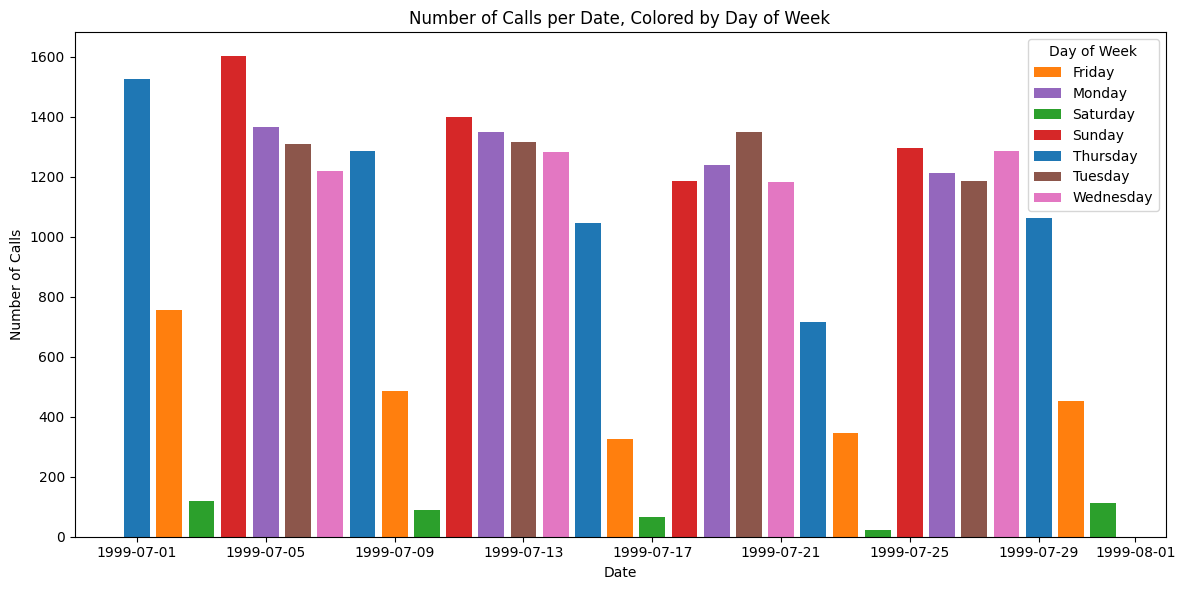

In [724]:
# Count the rows for each date

# Add day of week
cc_df['day_of_week'] = cc_df['date'].dt.day_name()
# Count the rows for each date and color by day of week
date_counts = cc_df.groupby(['date', 'day_of_week']).size().reset_index(name='count')
day_colors = dict(zip(cc_df['day_of_week'].unique(), sns.color_palette('tab10', n_colors=cc_df['day_of_week'].nunique())))
plt.figure(figsize=(12, 6))
for day, group in date_counts.groupby('day_of_week'):
    plt.bar(group['date'], group['count'], color=day_colors[day], label=day)
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.title('Number of Calls per Date, Colored by Day of Week')
plt.legend(title='Day of Week')
plt.tight_layout()
plt.show()

In [725]:
# Lets analyse the one with highest number of calls, which is 1999-04-11
highest_calls_date = date_counts.loc[date_counts['count'].idxmax(), 'date']
highest_calls_df = cc_df[cc_df['date'] == highest_calls_date]

highest_calls_df

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week
131,42020,PS,1999-07-04,1999-07-04 07:10:15,1999-07-04 07:10:29,14,0:00:00,0:00:00,0,AGENT,1999-07-04 07:10:28,1999-07-04 07:12:41,133,AVI,Sunday
132,42021,PS,1999-07-04,1999-07-04 07:29:57,1999-07-04 07:30:06,9,0:00:00,0:00:00,0,AGENT,1999-07-04 07:30:05,1999-07-04 07:34:32,267,YIFAT,Sunday
134,42023,PS,1999-07-04,1999-07-04 08:08:12,1999-07-04 08:08:19,7,8:08:19,8:08:40,21,AGENT,1999-07-04 08:08:39,1999-07-04 08:13:10,271,VICKY,Sunday
135,42024,PS,1999-07-04,1999-07-04 08:16:34,1999-07-04 08:16:41,7,8:16:41,8:17:06,25,AGENT,1999-07-04 08:17:04,1999-07-04 08:20:10,186,KAZAV,Sunday
137,42026,PS,1999-07-04,1999-07-04 08:36:44,1999-07-04 08:36:50,6,8:36:50,8:37:25,35,AGENT,1999-07-04 08:37:23,1999-07-04 08:39:37,134,AVI,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38181,7055,IN,1999-07-04,1999-07-04 17:26:08,1999-07-04 17:26:17,9,17:26:17,17:26:35,18,AGENT,1999-07-04 17:26:34,1999-07-04 17:30:13,219,YITZ,Sunday
38182,7056,PS,1999-07-04,1999-07-04 17:44:52,1999-07-04 17:44:58,6,17:44:58,17:48:57,239,AGENT,1999-07-04 17:48:56,1999-07-04 17:48:59,3,MORIAH,Sunday
38183,7057,IN,1999-07-04,1999-07-04 18:56:52,1999-07-04 18:57:01,9,18:57:01,19:04:14,433,AGENT,1999-07-04 19:04:14,1999-07-04 19:04:54,40,TOVA,Sunday
38184,7058,IN,1999-07-04,1999-07-04 19:36:13,1999-07-04 19:36:27,14,0:00:00,0:00:00,0,AGENT,1999-07-04 19:36:26,1999-07-04 19:43:48,442,TOVA,Sunday


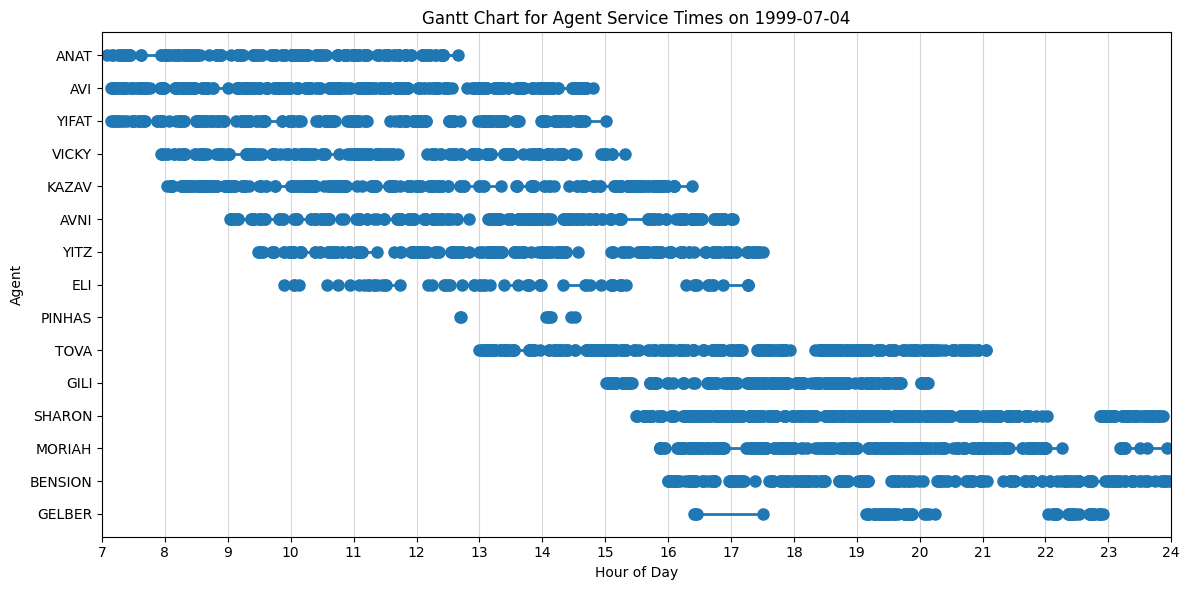

In [726]:
# Remove calls in service later than midnight and earlier than 7 AM
highest_calls_df = highest_calls_df[(highest_calls_df['ser_exit'].dt.hour >= 7) & (highest_calls_df['ser_exit'].dt.hour < 24)]

# Gantt chart for agents service times
# Assign a y position for each agent
agent_order = highest_calls_df['server'].unique()
# Sort agents by the first service start time
agent_order = highest_calls_df.groupby('server')['ser_start'].min().sort_values(ascending=False).index.to_numpy()
agent_to_y = {agent: i for i, agent in enumerate(agent_order)}

plt.figure(figsize=(12, 6))
for _, row in highest_calls_df.iterrows():
    y = agent_to_y[row['server']]
    x_start = row['ser_start'].hour + row['ser_start'].minute / 60 + row['ser_start'].second / 3600
    x_end = row['ser_exit'].hour + row['ser_exit'].minute / 60 + row['ser_exit'].second / 3600
    plt.hlines(y, x_start, x_end, color='tab:blue', linewidth=2)
    plt.plot([x_start, x_end], [y, y], 'o', color='tab:blue', markersize=8)  # blue dots

plt.xlabel('Hour of Day')
plt.ylabel('Agent')
plt.title(f'Gantt Chart for Agent Service Times on {highest_calls_date.date()}')
plt.xlim(7, 24)
plt.xticks(range(7, 25))
plt.yticks(range(len(agent_order)), agent_order)
plt.grid(True, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

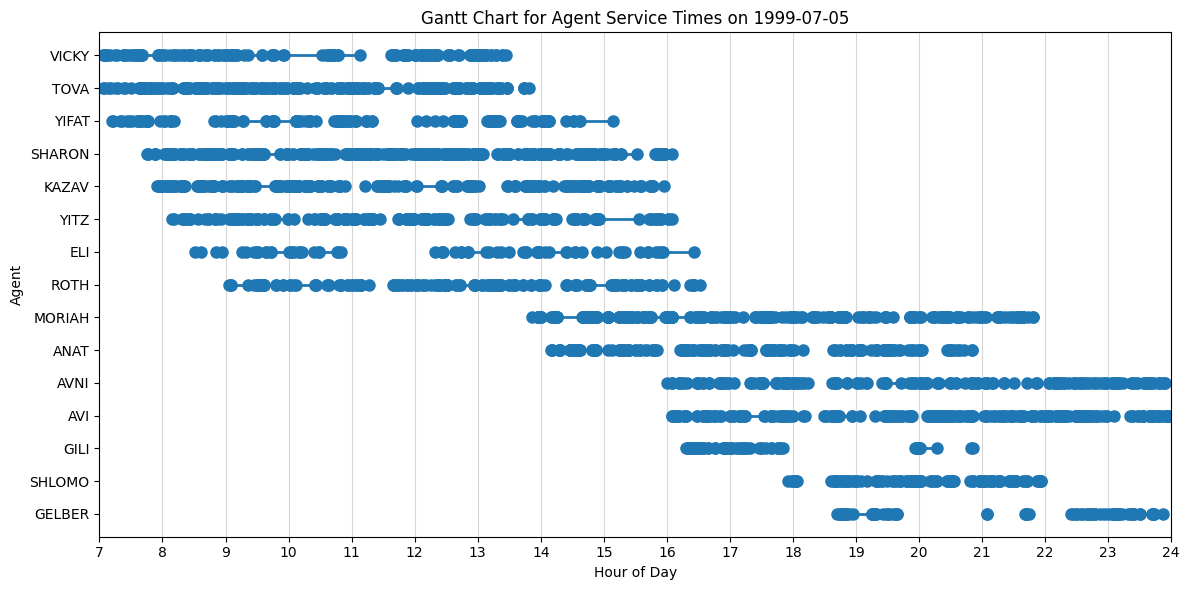

In [727]:
# Create gantt chart for the next day
next_day = highest_calls_date + pd.Timedelta(days=1)
next_day_df = cc_df[cc_df['date'] == next_day]

# Remove calls in service later than midnight and earlier than 7 AM
next_day_df = next_day_df[(next_day_df['ser_exit'].dt.hour >= 7) & (next_day_df['ser_exit'].dt.hour < 24)]

# Gantt chart for agents service times
# Assign a y position for each agent
agent_order_next = next_day_df['server'].unique()
agent_order_next = next_day_df.groupby('server')['ser_start'].min().sort_values(ascending=False).index.to_numpy()
agent_to_y_next = {agent: i for i, agent in enumerate(agent_order_next)}

plt.figure(figsize=(12, 6))
for _, row in next_day_df.iterrows():
    y = agent_to_y_next[row['server']]
    x_start = row['ser_start'].hour + row['ser_start'].minute / 60 + row['ser_start'].second / 3600
    x_end = row['ser_exit'].hour + row['ser_exit'].minute / 60 + row['ser_exit'].second / 3600
    plt.hlines(y, x_start, x_end, color='tab:blue', linewidth=2)
    plt.plot([x_start, x_end], [y, y], 'o', color='tab:blue', markersize=8)  # blue dots

plt.xlabel('Hour of Day')
plt.ylabel('Agent')
plt.title(f'Gantt Chart for Agent Service Times on {next_day.date()}')
plt.xlim(7, 24)
plt.xticks(range(7, 25))
plt.yticks(range(len(agent_order_next)), agent_order_next)
plt.grid(True, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

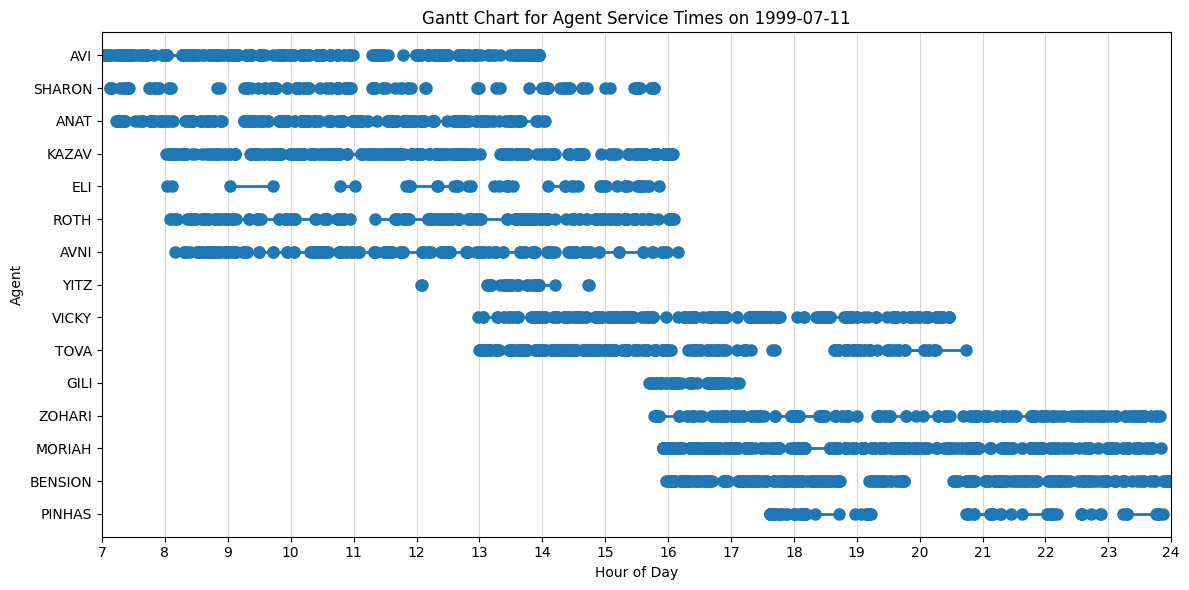

In [728]:
# Gantt chart for a week after the highest calls date
week_after_date = highest_calls_date + pd.Timedelta(days=7)
week_after_df = cc_df[(cc_df['date'] == week_after_date)]

# Remove calls in service later than midnight and earlier than 7 AM
week_after_df = week_after_df[(week_after_df['ser_exit'].dt.hour >= 7) & (week_after_df['ser_exit'].dt.hour < 24)]

# Gantt chart for agents service times
# Assign a y position for each agent
agent_order_week = week_after_df['server'].unique()
agent_order_week = week_after_df.groupby('server')['ser_start'].min().sort_values(ascending=False).index.to_numpy()
agent_to_y_week = {agent: i for i, agent in enumerate(agent_order_week)}

plt.figure(figsize=(12, 6))
for _, row in week_after_df.iterrows():
    y = agent_to_y_week[row['server']]
    x_start = row['ser_start'].hour + row['ser_start'].minute / 60 + row['ser_start'].second / 3600
    x_end = row['ser_exit'].hour + row['ser_exit'].minute / 60 + row['ser_exit'].second / 3600
    plt.hlines(y, x_start, x_end, color='tab:blue', linewidth=2)
    plt.plot([x_start, x_end], [y, y], 'o', color='tab:blue', markersize=8)  # blue dots

plt.xlabel('Hour of Day')
plt.ylabel('Agent')
plt.title(f'Gantt Chart for Agent Service Times on {week_after_date.date()}')
plt.xlim(7, 24)
plt.xticks(range(7, 25))
plt.yticks(range(len(agent_order_week)), agent_order_week)
plt.grid(True, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

### So different agents work at different times. But there are always 8 of them at one time

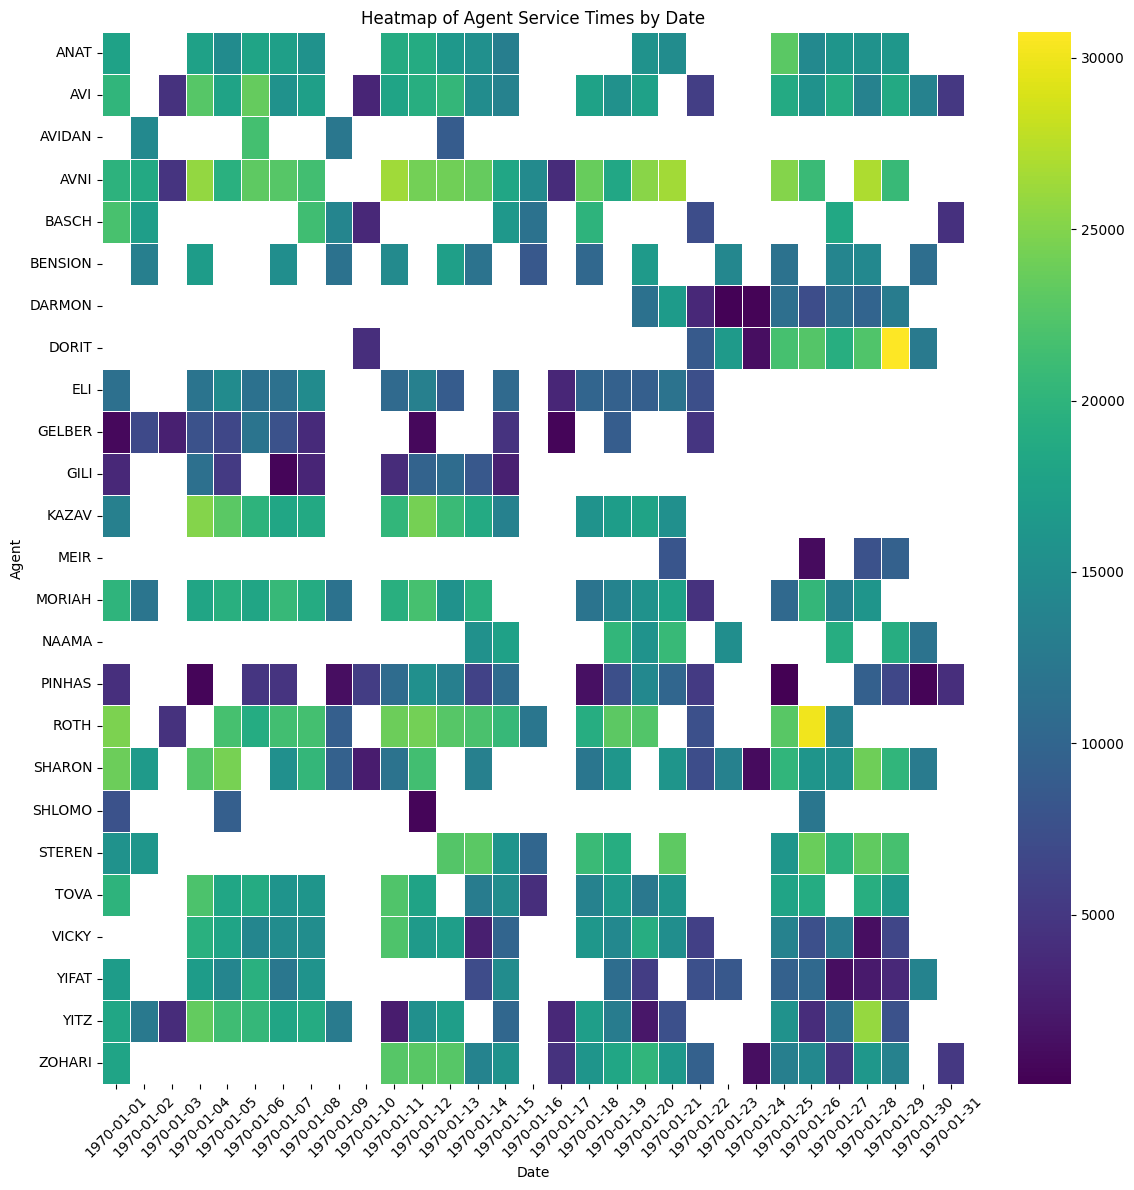

In [729]:
# Heatmap of agent service times each day
plt.figure(figsize=(12, 12))
# Create a pivot table for the heatmap
heatmap_data = cc_df.pivot_table(index='server', columns='date', values='ser_time', aggfunc='sum')
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt='.1f', linewidths=.5)
plt.title('Heatmap of Agent Service Times by Date')
plt.xlabel('Date')
plt.ylabel('Agent')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

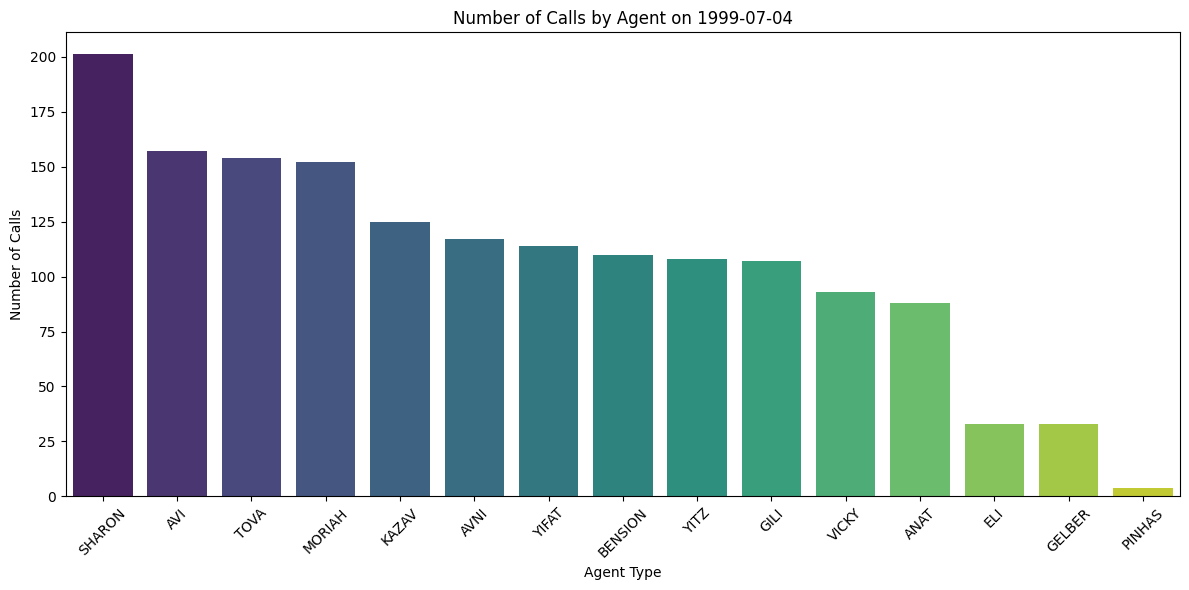

In [730]:
# Check the number of calls performed by each agent
agent_counts = highest_calls_df['server'].value_counts().reset_index()
agent_counts.columns = ['server', 'count']
plt.figure(figsize=(12, 6))
sns.barplot(x='server', y='count', data=agent_counts, palette='viridis', hue='server')
plt.xlabel('Agent Type')
plt.ylabel('Number of Calls')
plt.title(f'Number of Calls by Agent on {highest_calls_date.strftime("%Y-%m-%d")}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


No assignment pattern so we have to split manually or do clustering

### Let's split the call types into two types (simple and complex)

In [731]:
# Check rows with zero service time
cc_df[cc_df['ser_time'] == 0]

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week
218,42107,PS,1999-07-04,1999-07-04 20:02:31,1999-07-04 20:02:36,5,20:02:36,20:03:25,49,AGENT,1999-07-04 20:03:24,1999-07-04 20:03:24,0,GILI,Sunday
1294,43200,NE,1999-07-27,1999-07-27 09:34:35,1999-07-27 09:34:48,13,0:00:00,0:00:00,0,AGENT,1999-07-27 00:00:00,1999-07-27 00:00:00,0,ZOHARI,Tuesday
1456,43363,NE,1999-07-31,1999-07-31 22:37:40,1999-07-31 22:37:45,5,22:37:45,22:38:05,20,AGENT,1999-07-31 22:38:04,1999-07-31 22:38:04,0,AVI,Saturday
2904,38882,PS,1999-07-31,1999-07-31 22:17:33,1999-07-31 22:17:39,6,22:17:39,22:20:42,183,AGENT,1999-07-31 22:20:42,1999-07-31 22:20:42,0,AVI,Saturday
2937,33049,PS,1999-07-01,1999-07-01 13:50:30,1999-07-01 13:50:35,5,13:50:35,13:51:29,54,AGENT,1999-07-01 00:00:00,1999-07-01 00:00:00,0,YIFAT,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36504,23457,NE,1999-07-26,1999-07-26 10:11:52,1999-07-26 10:12:02,10,0:00:00,0:00:00,0,AGENT,1999-07-26 00:00:00,1999-07-26 00:00:00,0,ZOHARI,Monday
36706,23663,PS,1999-07-28,1999-07-28 16:12:59,1999-07-28 16:13:05,6,16:13:05,16:13:23,18,AGENT,1999-07-28 16:13:23,1999-07-28 16:13:23,0,BENSION,Wednesday
38000,22833,PS,1999-07-29,1999-07-29 09:38:48,1999-07-29 09:38:53,5,9:38:53,9:39:45,52,AGENT,1999-07-29 09:39:44,1999-07-29 09:39:44,0,AVI,Thursday
38098,22931,NE,1999-07-30,1999-07-30 10:24:10,1999-07-30 10:24:17,7,10:24:17,10:25:27,70,AGENT,1999-07-30 10:25:26,1999-07-30 10:25:26,0,AVI,Friday


In [732]:
# Remove rows with zero service time
cc_df = cc_df[cc_df['ser_time'] > 0]

In [733]:
cc_df['ser_time'].describe()

count    29047.000000
mean       186.628602
std        302.916378
min          1.000000
25%         61.000000
50%        116.000000
75%        220.000000
max      25561.000000
Name: ser_time, dtype: float64

In [734]:
# Group the data by type and calculate the number of calls per type
cc_df_grouped = cc_df.groupby('type')

cc_df_grouped_count = cc_df_grouped.size().reset_index(name='count')
cc_df_grouped_count = cc_df_grouped_count.sort_values(by='count', ascending=False)

# Display the counts of each call type
cc_df_grouped_count

,type,count
4,PS,21370
2,NW,3118
1,NE,3025
5,TT,826
0,IN,619
3,PE,89


In [735]:
# Display the first few rows of the grouped DataFrame
cc_df_grouped.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday
12,41898,NE,1999-07-01,1999-07-01 10:57:26,1999-07-01 10:57:33,7,10:57:33,10:59:26,113,AGENT,1999-07-01 10:59:26,1999-07-01 11:06:11,405,KAZAV,Thursday
24,41910,NE,1999-07-01,1999-07-01 12:31:01,1999-07-01 12:31:07,6,12:31:07,12:32:45,98,AGENT,1999-07-01 12:32:44,1999-07-01 12:33:30,46,SHARON,Thursday
25,41911,NE,1999-07-01,1999-07-01 12:40:21,1999-07-01 12:40:26,5,12:40:26,12:40:42,16,AGENT,1999-07-01 12:40:41,1999-07-01 12:44:20,219,SHARON,Thursday
29,41915,NE,1999-07-01,1999-07-01 13:17:05,1999-07-01 13:17:11,6,13:17:11,13:17:30,19,AGENT,1999-07-01 13:17:28,1999-07-01 13:18:01,33,BASCH,Thursday
30,41916,NE,1999-07-01,1999-07-01 13:30:13,1999-07-01 13:30:19,6,13:30:19,13:30:53,34,AGENT,1999-07-01 13:30:52,1999-07-01 13:32:59,127,ANAT,Thursday


Text(0.5, 1.0, 'Number of Calls per Type')

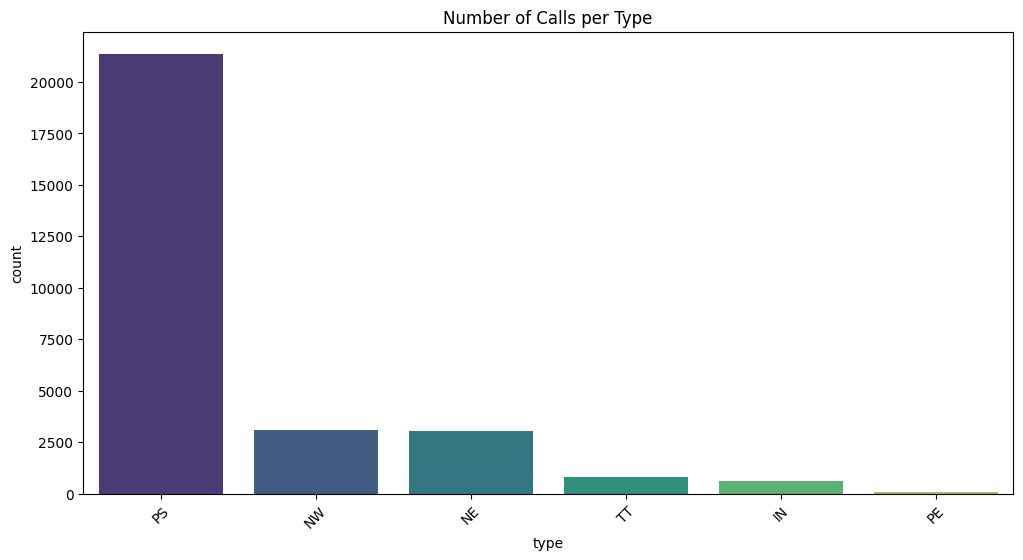

In [736]:
# Plot the number of calls per type
plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='count', data=cc_df_grouped_count, palette='viridis', hue='type')
plt.xticks(rotation=45)
plt.title('Number of Calls per Type')

In [737]:
# Describe service times of each type dataframes
cc_df_grouped['ser_time'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
IN,619.0,322.930533,1206.944704,1.0,69.5,130.0,249.0,25561.0
NE,3025.0,245.162314,298.101258,1.0,73.0,159.0,301.0,3868.0
NW,3118.0,130.663246,179.385981,1.0,41.0,77.0,153.0,2864.0
PE,89.0,331.887640,398.862486,2.0,142.0,236.0,415.0,3170.0
PS,21370.0,184.356715,242.067099,1.0,65.0,119.0,220.0,12510.0
TT,826.0,124.506053,335.711403,2.0,11.0,48.5,137.0,6889.0


In [738]:
# Check the rows with the longest service times for each type
longest_service_times = cc_df.loc[cc_df_grouped['ser_time'].idxmax()]
longest_service_times

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week
38889,7765,IN,1999-07-28,1999-07-28 15:14:06,1999-07-28 15:14:16,10,15:14:16,15:17:02,166,AGENT,1999-07-28 15:17:01,1999-07-28 22:23:02,25561,YITZ,Wednesday
29944,42728,NE,1999-07-08,1999-07-08 10:43:21,1999-07-08 10:43:40,19,0:00:00,0:00:00,0,AGENT,1999-07-08 10:43:39,1999-07-08 11:48:07,3868,ELI,Thursday
16387,43020,NW,1999-07-28,1999-07-28 15:43:03,1999-07-28 15:43:12,9,15:43:12,15:45:43,151,AGENT,1999-07-28 15:45:42,1999-07-28 16:33:26,2864,PINHAS,Wednesday
8524,44346,PE,1999-07-27,1999-07-27 23:03:05,1999-07-27 23:03:09,4,23:03:09,23:04:53,104,AGENT,1999-07-27 23:04:51,1999-07-27 23:57:41,3170,YITZ,Tuesday
35126,24221,PS,1999-07-29,1999-07-29 20:29:28,1999-07-29 20:29:34,6,20:29:34,20:30:27,53,AGENT,1999-07-29 20:30:27,1999-07-29 23:58:57,12510,DORIT,Thursday
9214,3436,TT,1999-07-26,1999-07-26 19:24:35,1999-07-26 19:24:37,2,0:00:00,0:00:00,0,AGENT,1999-07-26 19:24:36,1999-07-26 21:19:25,6889,SHLOMO,Monday


I think 7 hours of service is excessive and unrealistic, lets drop it

In [739]:
# Locate the top longest service time
longest_service_times = cc_df.loc[cc_df['ser_time'].idxmax()]

# Drop the call with the longest service time
cc_df = cc_df.drop(longest_service_times.name)

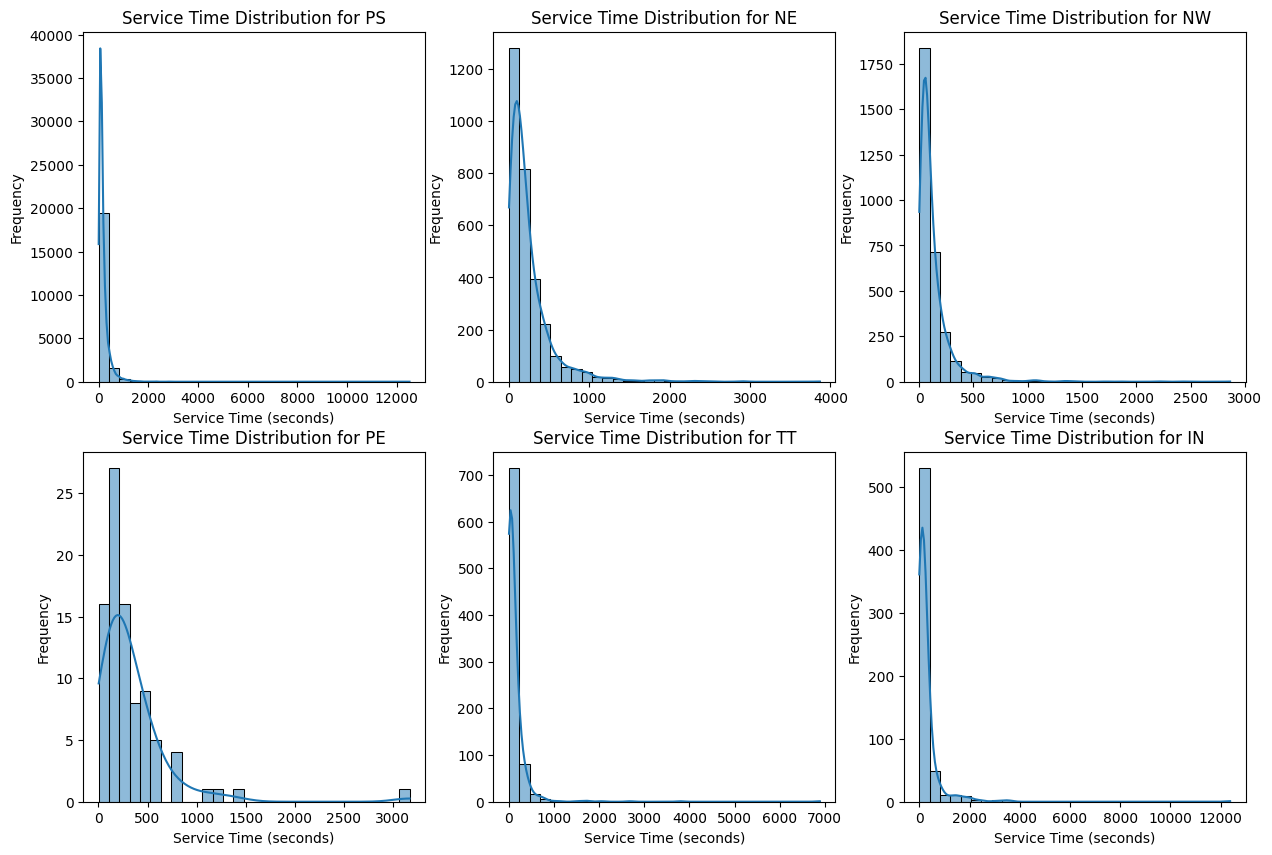

In [740]:
# Plot histogram of service times for each call type
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for i, call_type in enumerate(cc_df['type'].unique()):
    sns.histplot(cc_df[cc_df['type'] == call_type]['ser_time'], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Service Time Distribution for {call_type}')
    axes[i].set_xlabel('Service Time (seconds)')
    axes[i].set_ylabel('Frequency')

In [741]:
# QQ plot against exponential distribution
def qq_plot_exp(data, title):
    stats.probplot(data, dist="expon", plot=plt)
    plt.title(title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    
# QQ plot against lognormal distribution
def qq_plot_lognorm(data, title):
    shape, loc, scale = stats.lognorm.fit(data, floc=0)
    stats.probplot(data, dist="lognorm", sparams=(shape, loc, scale), plot=plt)
    plt.title(title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')

In [742]:
def ks_test_distributions_df(data):
    results = {}

    # Exponential: fit with data mean
    exp_params = (data.mean(),)
    d_exp, p_exp = stats.kstest(data, 'expon', args=exp_params)
    results['exponential'] = {'D-statistic': d_exp, 'p-value': p_exp}

    # Gamma: fit distribution to data
    gamma_params = stats.gamma.fit(data)
    d_gamma, p_gamma = stats.kstest(data, 'gamma', args=gamma_params)
    results['gamma'] = {'D-statistic': d_gamma, 'p-value': p_gamma}

    # Lognormal: fit distribution to data
    lognorm_params = stats.lognorm.fit(data)
    d_lognorm, p_lognorm = stats.kstest(data, 'lognorm', args=lognorm_params)
    results['lognormal'] = {'D-statistic': d_lognorm, 'p-value': p_lognorm}

    # Create DataFrame from results
    df = pd.DataFrame(results).T
    df['reject_null'] = df['p-value'] < 0.05

    # Find best fitting distribution
    best_fit = df['p-value'].idxmax()
    df['best_fit'] = best_fit
    return df


In [743]:
# Group the other call into one against 'PS'
# Because 'PS' is general query, we will call it 'SIMPLE'
cc_type_df = cc_df.copy()
cc_type_df['type_group'] = cc_type_df['type'].apply(lambda x: 'SIMPLE' if x == 'PS' else 'COMPLEX')

# Display the first few rows of the grouped DataFrame
cc_type_df.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday,SIMPLE
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday,SIMPLE
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday,SIMPLE
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday,SIMPLE
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday,SIMPLE


In [744]:
cc_type_df_grouped = cc_type_df.groupby('type_group')

cc_type_df_grouped['ser_time'].describe()

,count,mean,std,min,25%,50%,75%,max
type_group,,,,,,,,
COMPLEX,7676.0,189.647863,316.541846,1.0,46.0,105.5,218.0,12373.0
SIMPLE,21370.0,184.356715,242.067099,1.0,65.0,119.0,220.0,12510.0


### Now we need 2 agent groups from 15 agents. Lets see how each agent perform on simple and complex calls

### We will perform clustering to group them into two agent groups

In [745]:
# Calculate mean service time for each server and call type (SIMPLE, COMPLEX)
mean_ser_time = cc_type_df.groupby(['server', 'type_group'])['ser_time'].mean().unstack()
mean_ser_time = mean_ser_time.fillna(0)

mean_ser_time

type_group,COMPLEX,SIMPLE
server,,
ANAT,180.872659,199.019017
AVI,120.717633,138.247344
AVIDAN,158.813559,188.343137
AVNI,170.300797,246.886092
BASCH,157.373272,189.517941
BENSION,97.798165,127.363563
DARMON,268.532468,275.068966
DORIT,192.779817,216.832812
ELI,433.777778,361.764706


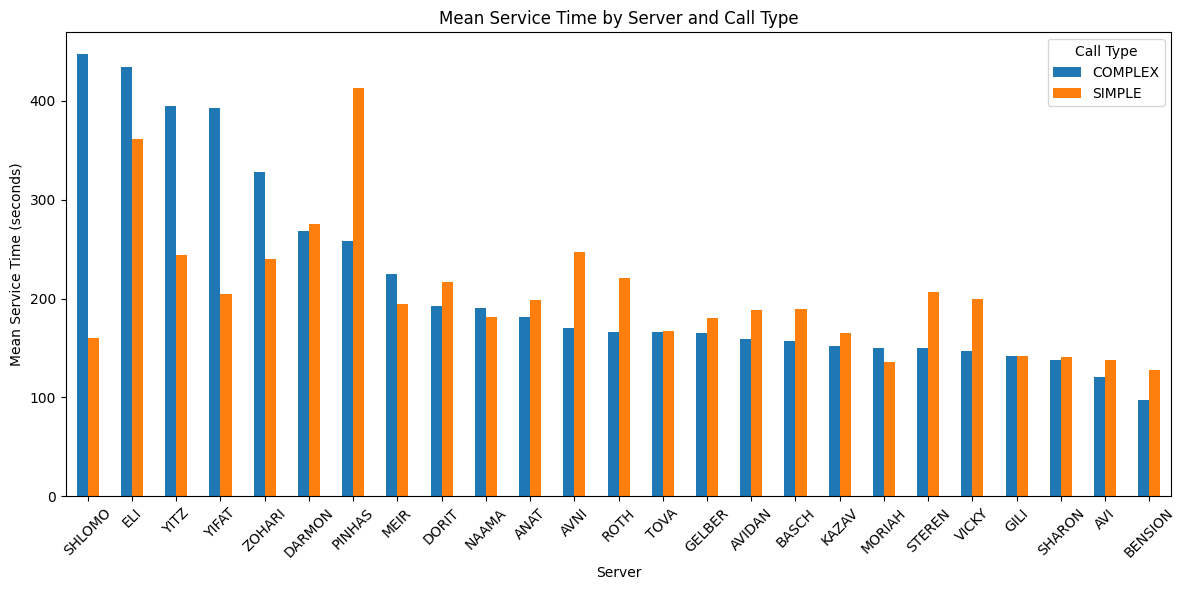

In [746]:
# Plot the mean service times for each server and call type
# Order by highest mean service time
mean_ser_time = mean_ser_time.sort_values(by='COMPLEX', ascending=False)
plt.figure(figsize=(12, 6))
mean_ser_time.plot(kind='bar', color=['#1f77b4', '#ff7f0e'], ax=plt.gca())
plt.xlabel('Server')
plt.ylabel('Mean Service Time (seconds)')
plt.title('Mean Service Time by Server and Call Type')
plt.legend(title='Call Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

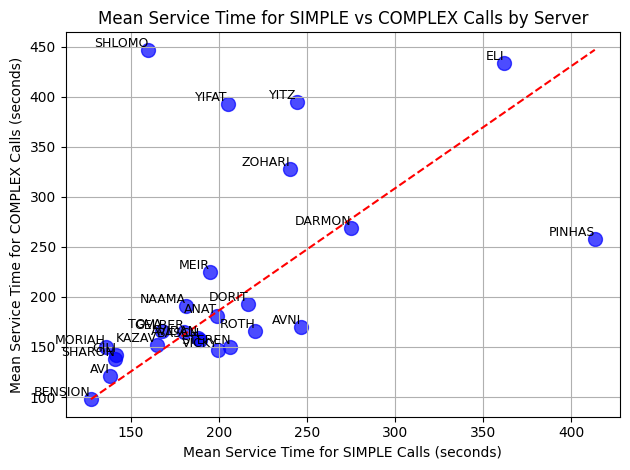

In [747]:
# Define the diagonal
simple_min = mean_ser_time['SIMPLE'].min()
simple_max = mean_ser_time['SIMPLE'].max()
complex_min = mean_ser_time['COMPLEX'].min()
complex_max = mean_ser_time['COMPLEX'].max()

# Create scatterplot of mean service times for each server and call type
plt.figure(figsize=(12, 6))
mean_ser_time.plot(kind='scatter', x='SIMPLE', y='COMPLEX', color='blue', s=100, alpha=0.7)
plt.xlabel('Mean Service Time for SIMPLE Calls (seconds)')
plt.ylabel('Mean Service Time for COMPLEX Calls (seconds)')
plt.title('Mean Service Time for SIMPLE vs COMPLEX Calls by Server')
# Add middle line (y = x)
plt.plot([simple_min, simple_max],
         [complex_min, complex_max],
         'r--', label='Mean service time')

# Label the dots with server names
for server, row in mean_ser_time.iterrows():
    plt.text(row['SIMPLE'], row['COMPLEX'], server, fontsize=9, ha='right', va='bottom')

# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [748]:
# Slope and intercept of the diagonal
m = (complex_max - complex_min) / (simple_max - simple_min)
c = complex_min - m * simple_min

# Calculate the y-value on the diagonal for each server's SIMPLE mean
diagonal_y = m * mean_ser_time['SIMPLE'] + c

# Find servers above and under the line
servers_above = mean_ser_time[mean_ser_time['COMPLEX'] > diagonal_y]
servers_under = mean_ser_time[mean_ser_time['COMPLEX'] < diagonal_y]

print("Servers ABOVE the plotted line:")
print(servers_above[['SIMPLE', 'COMPLEX']])

print("\nServers UNDER the plotted line:")
print(servers_under[['SIMPLE', 'COMPLEX']])

Servers ABOVE the plotted line:
type_group      SIMPLE     COMPLEX
server                            
SHLOMO      159.908163  446.838710
ELI         361.764706  433.777778
YITZ        244.134901  395.030151
YIFAT       205.054817  392.476471
ZOHARI      240.498322  327.569191
MEIR        194.906667  225.211538
NAAMA       181.256776  190.857143
TOVA        167.613037  165.768182
GELBER      180.160448  164.847458
KAZAV       165.104244  152.035533
MORIAH      135.926427  150.481742
GILI        141.678233  141.630000
SHARON      141.068376  137.796992
AVI         138.247344  120.717633

Servers UNDER the plotted line:
type_group      SIMPLE     COMPLEX
server                            
DARMON      275.068966  268.532468
PINHAS      413.367816  257.866935
DORIT       216.832812  192.779817
ANAT        199.019017  180.872659
AVNI        246.886092  170.300797
ROTH        220.586985  166.212308
AVIDAN      188.343137  158.813559
BASCH       189.517941  157.373272
STEREN      206.561886  1

In [749]:
# Group the servers into two groups based on their position relative to the diagonal
mean_ser_time['group'] = np.where(mean_ser_time['COMPLEX'] > diagonal_y, '1', '2')

# Check the grouped means
grouped_means = (
    mean_ser_time.groupby('group')[['SIMPLE', 'COMPLEX']].mean()
)

print(grouped_means)

type_group      SIMPLE     COMPLEX
group                             
1           189.808747  246.074180
2           225.736929  177.005371


In [750]:
mean_ser_time

type_group,COMPLEX,SIMPLE,group
server,,,
SHLOMO,446.838710,159.908163,1
ELI,433.777778,361.764706,1
YITZ,395.030151,244.134901,1
YIFAT,392.476471,205.054817,1
ZOHARI,327.569191,240.498322,1
DARMON,268.532468,275.068966,2
PINHAS,257.866935,413.367816,2
MEIR,225.211538,194.906667,1
DORIT,192.779817,216.832812,2


In [751]:
# Apply the grouping to the main dataframe
cc_type_df['group'] = np.where(cc_type_df['server'].isin(servers_above.index), '1', '2')

cc_type_df

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday,SIMPLE,1
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday,SIMPLE,2
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday,SIMPLE,1
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday,SIMPLE,1
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday,SIMPLE,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39010,7886,IN,1999-07-30,1999-07-30 12:46:50,1999-07-30 12:46:59,9,12:46:59,12:48:28,89,AGENT,1999-07-30 12:48:27,1999-07-30 12:49:47,80,BENSION,Friday,COMPLEX,2
39011,7887,IN,1999-07-30,1999-07-30 13:01:19,1999-07-30 13:01:38,19,0:00:00,0:00:00,0,AGENT,1999-07-30 13:01:37,1999-07-30 13:15:12,815,BENSION,Friday,COMPLEX,2
39012,7888,IN,1999-07-30,1999-07-30 13:30:21,1999-07-30 13:30:36,15,0:00:00,0:00:00,0,AGENT,1999-07-30 13:30:35,1999-07-30 13:32:58,143,SHARON,Friday,COMPLEX,1
39019,7895,IN,1999-07-31,1999-07-31 22:09:48,1999-07-31 22:10:07,19,0:00:00,0:00:00,0,AGENT,1999-07-31 22:10:06,1999-07-31 22:11:46,100,AVI,Saturday,COMPLEX,1


In [752]:
# Calculate daily average and variance for each group
grouped_daily = cc_type_df.groupby(['date', 'group'])['ser_time'].agg(['mean', 'var']).reset_index()

mean_pivot = grouped_daily.pivot(index='date', columns='group', values='mean')
var_pivot = grouped_daily.pivot(index='date', columns='group', values='var')

mean_pivot, var_pivot

(group                1           2
 date                              
 1999-07-01  178.201232  192.453704
 1999-07-02  164.896907  171.504310
 1999-07-03  139.835443  224.195122
 1999-07-04  153.772227  195.191748
 1999-07-05  170.843811  218.088496
 1999-07-06  175.724054  208.289855
 1999-07-07  183.825203  200.995816
 1999-07-08  178.785455  209.766004
 1999-07-09  152.288288  182.011321
 1999-07-10  121.531915  302.674419
 1999-07-11  164.516939  195.848739
 1999-07-12  192.800231  206.962422
 1999-07-13  217.447566  183.180412
 1999-07-14  173.902954  184.329204
 1999-07-15  205.872822  223.193206
 1999-07-16  144.714286  190.993289
 1999-07-17  275.000000  172.500000
 1999-07-18  189.524046  192.854671
 1999-07-19  184.437140  223.615176
 1999-07-20  161.319889  201.527419
 1999-07-21  170.490814  254.779904
 1999-07-22  107.986079  136.755396
 1999-07-23  189.056410  208.053333
 1999-07-24  159.769231  170.111111
 1999-07-25  184.293706  203.063025
 1999-07-26  198.987654  198

In [ ]:
# Check records from 16 July that broke the calculations
# cc_type_df[(cc_type_df['group'] == 1) & (cc_type_df['date'] == '1999-07-16')]['ser_time']

Series([], Name: ser_time, dtype: int64)

In [ ]:
# cc_type_df.loc[cc_type_df['date'] == '1999-07-16', ['ser_time', 'group']]

,ser_time,group
901,98,2
902,63,2
903,146,2
904,75,2
905,616,2
...,...,...
15346,31,2
15347,155,2
15348,1,2
15349,81,2


Apparently there were no one from group 1 working on July 16th

In [ ]:
# cc_type_df[cc_type_df['group'] == '1']['ser_time'].count(), cc_type_df[cc_type_df['group'] == '2']['ser_time'].count()

(np.int64(9515), np.int64(19531))

So the count of group 1 is much smaller, less than half of group 2

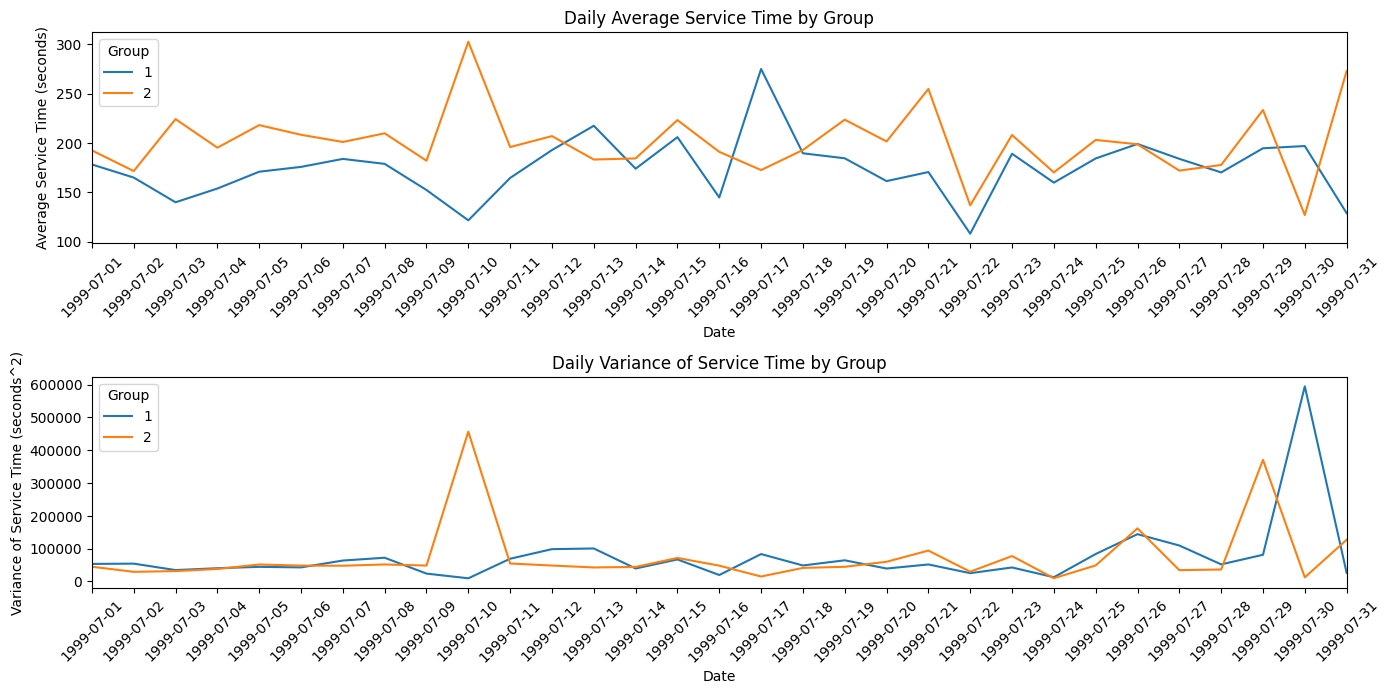

In [754]:
# Plot the average and variance as time series
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
ax1 = plt.gca()
mean_pivot.plot(ax=ax1)
plt.title('Daily Average Service Time by Group')
plt.xlabel('Date')
plt.ylabel('Average Service Time (seconds)')
plt.legend(title='Group')
# Force all dates to appear as x-ticks
ax1.set_xticks(mean_pivot.index)
ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in mean_pivot.index], rotation=45)

plt.subplot(2, 1, 2)
ax2 = plt.gca()
var_pivot.plot(ax=ax2)
plt.title('Daily Variance of Service Time by Group')
plt.xlabel('Date')
plt.ylabel('Variance of Service Time (seconds^2)')
plt.legend(title='Group')
plt.tight_layout()
# Force all dates to appear as x-ticks
ax2.set_xticks(var_pivot.index)
ax2.set_xticklabels([date.strftime('%Y-%m-%d') for date in var_pivot.index], rotation=45)

plt.show()

Let's shift our line a bit to make it more equal, by 12.5% of the mean

<Figure size 1200x600 with 0 Axes>

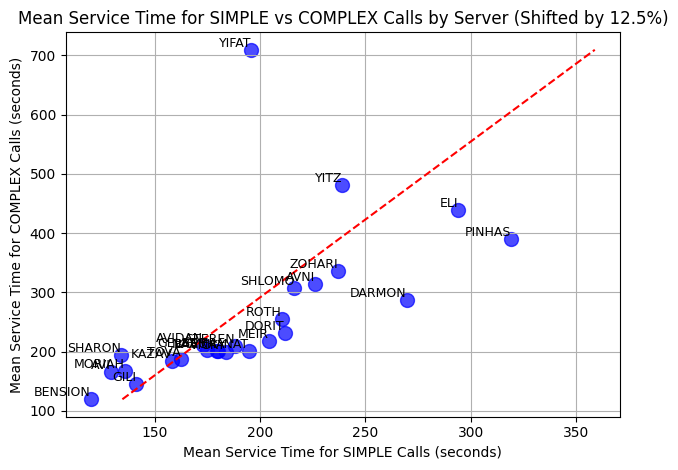

In [463]:
# Create scatterplot of mean service times for each server and call type
plt.figure(figsize=(12, 6))
mean_ser_time.plot(kind='scatter', x='SIMPLE', y='COMPLEX', color='blue', s=100, alpha=0.7)
plt.xlabel('Mean Service Time for SIMPLE Calls (seconds)')
plt.ylabel('Mean Service Time for COMPLEX Calls (seconds)')
plt.title('Mean Service Time for SIMPLE vs COMPLEX Calls by Server (Shifted by 12.5%)')
# Add middle line (y = x)
plt.plot([simple_min + (simple_min * 0.125), simple_max + (simple_max * 0.125)],
         [complex_min, complex_max],
         'r--', label='Mean service time')

# Label the dots with server names
for server, row in mean_ser_time.iterrows():
    plt.text(row['SIMPLE'], row['COMPLEX'], server, fontsize=9, ha='right', va='bottom')

# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [464]:
# Compute shifted line endpoints
simple_min_shifted = simple_min + (simple_min * 0.125)
simple_max_shifted = simple_max + (simple_max * 0.125)

# Slope and intercept of the moved diagonal
m = (complex_max - complex_min) / (simple_max_shifted - simple_min_shifted)
c = complex_min - m * simple_min_shifted

# Calculate the y-value on the moved diagonal for each server's SIMPLE mean
diagonal_y = m * mean_ser_time['SIMPLE'] + c

# Find servers above and under the moved diagonal line
servers_above = mean_ser_time[mean_ser_time['COMPLEX'] > diagonal_y]
servers_under = mean_ser_time[mean_ser_time['COMPLEX'] < diagonal_y]

print("Servers count per group:")
print(servers_above.shape[0], "servers above the shifted line")
print(servers_under.shape[0], "servers under the shifted line")

print("Servers ABOVE the shifted line:")
print(servers_above[['SIMPLE', 'COMPLEX']])

print("\nServers UNDER the shifted line:")
print(servers_under[['SIMPLE', 'COMPLEX']])

Servers count per group:
8 servers above the shifted line
17 servers under the shifted line
Servers ABOVE the shifted line:
type_group      SIMPLE     COMPLEX
server                            
YIFAT       195.783046  709.197368
YITZ        239.047564  481.468966
SHARON      133.853551  193.588889
KAZAV       158.307278  184.620553
MORIAH      135.844530  168.140673
AVI         129.253221  164.973684
GILI        141.183562  145.057692
BENSION     119.698331  119.717742

Servers UNDER the shifted line:
type_group      SIMPLE     COMPLEX
server                            
ELI         294.041667  439.517520
PINHAS      318.945545  390.166667
ZOHARI      236.955738  336.728997
AVNI        226.016732  314.016949
SHLOMO      216.261261  306.555556
DARMON      269.473029  287.500000
ROTH        210.349198  255.083333
DORIT       211.704082  231.063492
MEIR        204.323232  217.892857
AVIDAN      172.698582  211.525000
STEREN      187.932647  210.198758
GELBER      174.989446  202.000000
ANA

In [465]:
# Group the servers into two groups based on their position relative to the diagonal
mean_ser_time['group_2'] = np.where(mean_ser_time['COMPLEX'] > diagonal_y, '1', '2')

# Check the grouped means
grouped_means = (
    mean_ser_time.groupby('group_2')[['SIMPLE', 'COMPLEX']].mean()
)

print(grouped_means)

type_group      SIMPLE     COMPLEX
group_2                           
1           156.621385  270.845696
2           213.179047  258.464185


In [466]:
# Apply second grouping to the main dataframe
cc_type_df['group_2'] = np.where(cc_type_df['server'].isin(servers_above.index), '1', '2')

cc_type_df

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group,group_2
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday,SIMPLE,1,1
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday,SIMPLE,2,2
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday,SIMPLE,2,1
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday,SIMPLE,1,1
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday,SIMPLE,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39010,7886,IN,1999-07-30,1999-07-30 12:46:50,1999-07-30 12:46:59,9,12:46:59,12:48:28,89,AGENT,1999-07-30 12:48:27,1999-07-30 12:49:47,80,BENSION,Friday,COMPLEX,2,1
39011,7887,IN,1999-07-30,1999-07-30 13:01:19,1999-07-30 13:01:38,19,0:00:00,0:00:00,0,AGENT,1999-07-30 13:01:37,1999-07-30 13:15:12,815,BENSION,Friday,COMPLEX,2,1
39012,7888,IN,1999-07-30,1999-07-30 13:30:21,1999-07-30 13:30:36,15,0:00:00,0:00:00,0,AGENT,1999-07-30 13:30:35,1999-07-30 13:32:58,143,SHARON,Friday,COMPLEX,1,1
39019,7895,IN,1999-07-31,1999-07-31 22:09:48,1999-07-31 22:10:07,19,0:00:00,0:00:00,0,AGENT,1999-07-31 22:10:06,1999-07-31 22:11:46,100,AVI,Saturday,COMPLEX,1,1


In [467]:
# Check the number of calls performed by each group
cc_type_df[cc_type_df['group_2'] == '1']['ser_time'].count(), cc_type_df[cc_type_df['group_2'] == '2']['ser_time'].count()

(np.int64(13351), np.int64(15695))

So this grouping looks better.
* The difference of server number per group is smaller
* The service time for each group and each call type still follow the rule, although the difference between complex call service time is small
* Call count split almost evenly

In [468]:
# Calculate daily average and variance for each group
grouped_daily = cc_type_df.groupby(['date', 'group_2'])['ser_time'].agg(['mean', 'var']).reset_index()

mean_pivot = grouped_daily.pivot(index='date', columns='group_2', values='mean')
var_pivot = grouped_daily.pivot(index='date', columns='group_2', values='var')

mean_pivot, var_pivot

(group_2              1           2
 date                              
 1999-07-01  167.239538  196.828258
 1999-07-02  148.543716  188.164524
 1999-07-03  113.328767  254.595745
 1999-07-04  146.307190  201.779693
 1999-07-05  161.664083  210.502573
 1999-07-06  164.446602  208.909357
 1999-07-07  169.502196  217.577861
 1999-07-08  168.790732  212.809524
 1999-07-09  142.757862  216.828402
 1999-07-10  121.531915  302.674419
 1999-07-11  131.482507  223.021246
 1999-07-12  176.725118  216.619382
 1999-07-13  171.915683  218.018131
 1999-07-14  150.236334  205.418960
 1999-07-15  203.784387  217.109536
 1999-07-16  104.061728  214.444898
 1999-07-17  291.750000  228.660377
 1999-07-18  155.952294  221.319182
 1999-07-19  160.020408  224.060258
 1999-07-20  128.909091  219.288360
 1999-07-21  135.430622  235.960630
 1999-07-22   93.184211  134.927765
 1999-07-23  170.848341  238.992537
 1999-07-24  154.666667  167.500000
 1999-07-25  156.169091  223.519022
 1999-07-26  178.865229  207

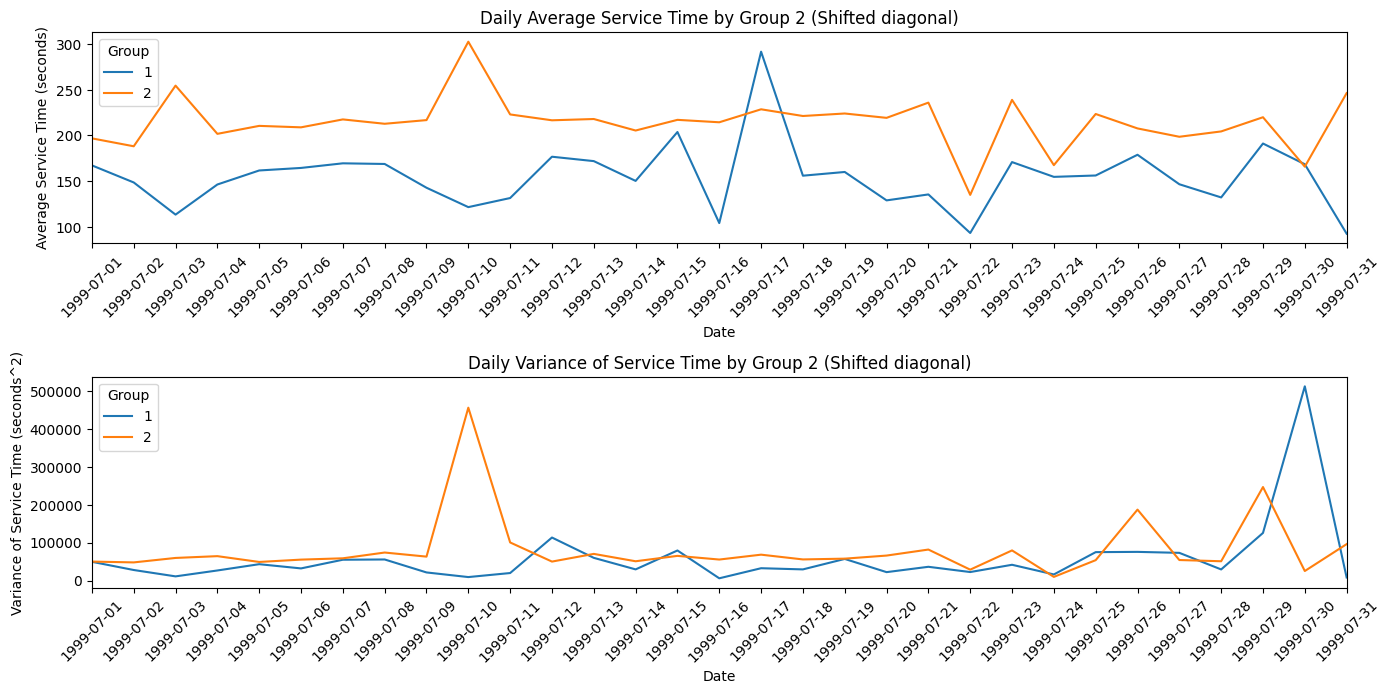

In [469]:
# Plot the average and variance as time series
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
ax1 = plt.gca()
mean_pivot.plot(ax=ax1)
plt.title('Daily Average Service Time by Group 2 (Shifted diagonal)')
plt.xlabel('Date')
plt.ylabel('Average Service Time (seconds)')
plt.legend(title='Group')
# Force all dates to appear as x-ticks
ax1.set_xticks(mean_pivot.index)
ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in mean_pivot.index], rotation=45)

plt.subplot(2, 1, 2)
ax2 = plt.gca()
var_pivot.plot(ax=ax2)
plt.title('Daily Variance of Service Time by Group 2 (Shifted diagonal)')
plt.xlabel('Date')
plt.ylabel('Variance of Service Time (seconds^2)')
plt.legend(title='Group')
plt.tight_layout()
# Force all dates to appear as x-ticks
ax2.set_xticks(var_pivot.index)
ax2.set_xticklabels([date.strftime('%Y-%m-%d') for date in var_pivot.index], rotation=45)

plt.show()

### Let's try performing Ward's clustering

In [470]:
scaler = StandardScaler()
X = scaler.fit_transform(mean_ser_time[['SIMPLE', 'COMPLEX']])

clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
mean_ser_time['cluster'] = clustering.fit_predict(X)

mean_ser_time

type_group,COMPLEX,SIMPLE,group,group_2,cluster
server,,,,,
YIFAT,709.197368,195.783046,1,1,0
YITZ,481.468966,239.047564,1,1,0
ELI,439.517520,294.041667,2,2,0
PINHAS,390.166667,318.945545,2,2,0
ZOHARI,336.728997,236.955738,2,2,0
AVNI,314.016949,226.016732,2,2,0
SHLOMO,306.555556,216.261261,2,2,0
DARMON,287.500000,269.473029,2,2,0
ROTH,255.083333,210.349198,2,2,1


In [471]:
# Check the average service time for each cluster
mean_ser_time.groupby('cluster')[['SIMPLE', 'COMPLEX']].mean()

type_group,SIMPLE,COMPLEX
cluster,,
0,249.565573,408.144003
1,169.440605,193.853217


In [472]:
# Apply the grouping to the main dataframe
cc_type_df['cluster'] = np.where(cc_type_df['server'].isin(mean_ser_time[mean_ser_time['cluster'] == 0].index), '0', '1')

# Check the number of calls performed by each group
cc_type_df[cc_type_df['cluster'] == '0']['ser_time'].count(), cc_type_df[cc_type_df['cluster'] == '1']['ser_time'].count()

(np.int64(6104), np.int64(22942))

In [473]:
# Calculate daily average and variance for each group
grouped_daily = cc_type_df.groupby(['date', 'cluster'])['ser_time'].agg(['mean', 'var']).reset_index()

mean_pivot = grouped_daily.pivot(index='date', columns='cluster', values='mean')
var_pivot = grouped_daily.pivot(index='date', columns='cluster', values='var')

mean_pivot, var_pivot

(cluster               0           1
 date                               
 1999-07-01   223.544186  167.314576
 1999-07-02   223.525180  156.644481
 1999-07-03   199.325581  151.532468
 1999-07-04   208.436170  150.905505
 1999-07-05   230.391813  166.558621
 1999-07-06   220.961111  175.133758
 1999-07-07   226.255738  178.628979
 1999-07-08   271.789272  168.716814
 1999-07-09   209.651515  162.004751
 1999-07-10  1823.666667  152.367816
 1999-07-11   279.369231  154.606007
 1999-07-12   263.965318  174.942943
 1999-07-13   304.329787  167.747082
 1999-07-14   241.253589  166.231490
 1999-07-15   299.298507  184.148005
 1999-07-16   248.728814  173.382022
 1999-07-17   240.539683  233.000000
 1999-07-18   301.265487  165.096335
 1999-07-19   262.223729  175.414453
 1999-07-20   289.414474  147.781643
 1999-07-21   345.728682  159.668113
 1999-07-22   196.923077   94.962963
 1999-07-23   331.961538  186.341693
 1999-07-24   187.000000  150.857143
 1999-07-25   324.860262  166.518448
 

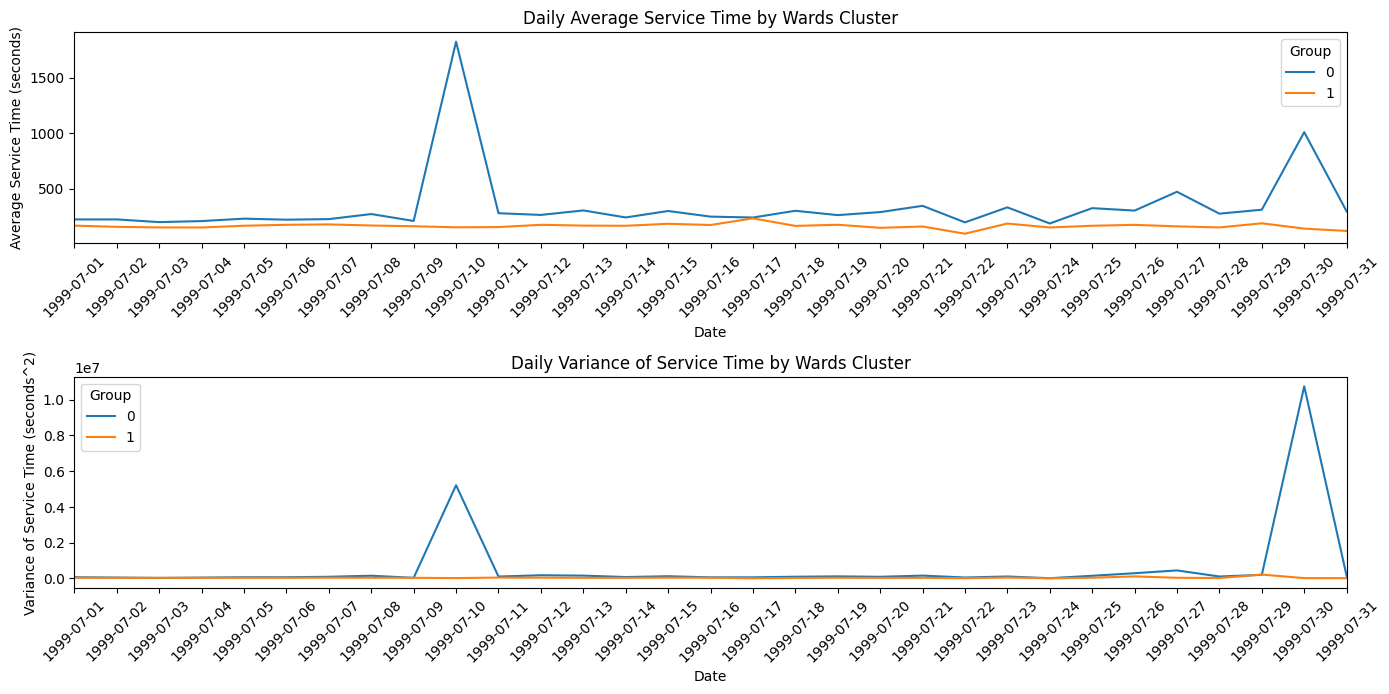

In [474]:
# Plot the average and variance as time series
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
ax1 = plt.gca()
mean_pivot.plot(ax=ax1)
plt.title('Daily Average Service Time by Wards Cluster')
plt.xlabel('Date')
plt.ylabel('Average Service Time (seconds)')
plt.legend(title='Group')
# Force all dates to appear as x-ticks
ax1.set_xticks(mean_pivot.index)
ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in mean_pivot.index], rotation=45)

plt.subplot(2, 1, 2)
ax2 = plt.gca()
var_pivot.plot(ax=ax2)
plt.title('Daily Variance of Service Time by Wards Cluster')
plt.xlabel('Date')
plt.ylabel('Variance of Service Time (seconds^2)')
plt.legend(title='Group')
plt.tight_layout()
# Force all dates to appear as x-ticks
ax2.set_xticks(var_pivot.index)
ax2.set_xticklabels([date.strftime('%Y-%m-%d') for date in var_pivot.index], rotation=45)

plt.show()

From the ward clustering method we see how the spike in one particular date still happens, this is because of the outlier

In [478]:
# Display mean service time for each grouping (group, group_2, cluster)

# Display mean service time for each grouping (group, group_2, cluster)
display(mean_ser_time.groupby('group')[['SIMPLE', 'COMPLEX']].mean())
display(mean_ser_time.groupby('group_2')[['SIMPLE', 'COMPLEX']].mean())
display(mean_ser_time.groupby('cluster')[['SIMPLE', 'COMPLEX']].mean())

type_group,SIMPLE,COMPLEX
group,,
1,166.756382,343.473916
2,202.161648,242.164357


type_group,SIMPLE,COMPLEX
group_2,,
1,156.621385,270.845696
2,213.179047,258.464185


type_group,SIMPLE,COMPLEX
cluster,,
0,249.565573,408.144003
1,169.440605,193.853217


### Let's finalise and decide to use group_2 to proceed

In [479]:
# Finalise dataframe, exclude the group and cluster columns

cc_final_df = cc_type_df.copy()
cc_final_df = cc_final_df.drop(columns=['group', 'cluster'])

cc_final_df.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group_2
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday,SIMPLE,1
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday,SIMPLE,2
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday,SIMPLE,1
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday,SIMPLE,1
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday,SIMPLE,2


### Let's calculate the interarrival times

In [521]:
# Split dataframe to simple and complex calls df

cc_simple_df = cc_final_df[cc_final_df['type_group'] == 'SIMPLE'].copy()
cc_complex_df = cc_final_df[cc_final_df['type_group'] == 'COMPLEX'].copy()

cc_simple_df = cc_simple_df.sort_values(by='vru_entry')
cc_complex_df = cc_complex_df.sort_values(by='vru_entry')

# Calculate interarrival times
cc_simple_df['interarrival_time'] = (
    cc_simple_df.groupby('date')['vru_entry'].diff().dt.total_seconds()
    )
cc_complex_df['interarrival_time'] = (
    cc_complex_df.groupby('date')['vru_entry'].diff().dt.total_seconds()
    )

# Move columns near vru_entry
cc_simple_df = cc_simple_df[['call_id', 'type', 'date', 'vru_entry', 'interarrival_time'] + [col for col in cc_simple_df.columns if col not in ['call_id', 'type', 'date', 'vru_entry', 'interarrival_time']]]
cc_complex_df = cc_complex_df[['call_id', 'type', 'date', 'vru_entry', 'interarrival_time'] + [col for col in cc_complex_df.columns if col not in ['call_id', 'type', 'date', 'vru_entry', 'interarrival_time']]]

cc_simple_df['interarrival_time'].count(), cc_complex_df['interarrival_time'].count(), \
    cc_simple_df.head(), cc_complex_df.head()

(np.int64(25025),
 np.int64(3664),
    call_id type       date           vru_entry  interarrival_time  \
 0    36802   PS 1999-07-01 1999-07-01 07:02:02                NaN   
 1    29648   NW 1999-07-01 1999-07-01 07:02:06                4.0   
 2    43009   NW 1999-07-01 1999-07-01 07:04:39              153.0   
 3    42243   PS 1999-07-01 1999-07-01 07:07:42              183.0   
 4    11120   PS 1999-07-01 1999-07-01 07:07:55               13.0   
 
              vru_exit  vru_time  q_start   q_exit  q_time outcome  \
 0 1999-07-01 07:02:11         9  0:00:00  0:00:00       0   AGENT   
 1 1999-07-01 07:02:15         9  7:02:15  7:03:17      62   AGENT   
 2 1999-07-01 07:04:48         9  7:04:48  7:06:52     124   AGENT   
 3 1999-07-01 07:07:52        10  0:00:00  0:00:00       0   AGENT   
 4 1999-07-01 07:08:09        14  0:00:00  0:00:00       0   AGENT   
 
             ser_start            ser_exit  ser_time  server day_of_week  \
 0 1999-07-01 07:02:11 1999-07-01 07:02:22   

In [488]:
cc_simple_df['interarrival_time'].describe(), cc_complex_df['interarrival_time'].describe()

(count    25283.000000
 mean        57.341297
 std         70.109292
 min          0.000000
 25%         15.000000
 50%         36.000000
 75%         74.500000
 max       1671.000000
 Name: interarrival_time, dtype: float64,
 count    3701.000000
 mean      366.806539
 std       515.849746
 min         0.000000
 25%        89.000000
 50%       211.000000
 75%       447.000000
 max      6531.000000
 Name: interarrival_time, dtype: float64)

In [490]:
# Check top 10 largest interarrival times
cc_simple_df.nlargest(10, 'interarrival_time')

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group_2
881,42782,PS,1999-07-15,1999-07-15 18:53:01,1671.0,1999-07-15 18:53:15,14,0:00:00,0:00:00,0,AGENT,1999-07-15 18:53:14,1999-07-15 19:01:28,494,AVNI,Thursday,SIMPLE,2
864,42765,PS,1999-07-15,1999-07-15 16:26:34,1444.0,1999-07-15 16:27:00,26,0:00:00,0:00:00,0,AGENT,1999-07-15 16:26:59,1999-07-15 16:28:10,71,AVNI,Thursday,SIMPLE,2
2428,38395,PS,1999-07-18,1999-07-18 10:32:32,1160.0,1999-07-18 10:32:43,11,0:00:00,0:00:00,0,AGENT,1999-07-18 10:32:41,1999-07-18 10:33:12,31,AVI,Sunday,SIMPLE,1
21767,43145,PS,1999-07-22,1999-07-22 14:36:08,1010.0,1999-07-22 14:36:14,6,14:36:14,14:36:37,23,AGENT,1999-07-22 14:36:35,1999-07-22 14:39:09,154,VICKY,Thursday,SIMPLE,2
901,42803,PS,1999-07-16,1999-07-16 07:30:04,964.0,1999-07-16 07:30:17,13,0:00:00,0:00:00,0,AGENT,1999-07-16 07:30:16,1999-07-16 07:31:54,98,TOVA,Friday,SIMPLE,2
23365,45496,PS,1999-07-22,1999-07-22 14:19:18,961.0,1999-07-22 14:19:27,9,0:00:00,0:00:00,0,AGENT,1999-07-22 14:19:26,1999-07-22 14:20:06,40,VICKY,Thursday,SIMPLE,2
36310,23261,PS,1999-07-21,1999-07-21 21:00:24,952.0,1999-07-21 21:00:37,13,0:00:00,0:00:00,0,AGENT,1999-07-21 21:00:36,1999-07-21 21:03:05,149,SHARON,Wednesday,SIMPLE,1
969,42871,PS,1999-07-18,1999-07-18 10:04:01,934.0,1999-07-18 10:04:11,10,0:00:00,0:00:00,0,AGENT,1999-07-18 10:04:10,1999-07-18 10:04:22,12,AVNI,Sunday,SIMPLE,2
34692,23775,PS,1999-07-23,1999-07-23 14:22:53,909.0,1999-07-23 14:23:04,11,0:00:00,0:00:00,0,AGENT,1999-07-23 14:23:04,1999-07-23 14:23:24,20,DORIT,Friday,SIMPLE,2
14877,22077,NW,1999-07-22,1999-07-22 07:59:23,895.0,1999-07-22 07:59:41,18,0:00:00,0:00:00,0,AGENT,1999-07-22 07:59:40,1999-07-22 08:02:05,145,AVI,Thursday,SIMPLE,1


In [491]:
cc_complex_df.nlargest(10, 'interarrival_time')

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group_2
15374,6343,IN,1999-07-18,1999-07-18 22:21:47,6531.0,1999-07-18 22:22:06,19,0:00:00,0:00:00,0,AGENT,1999-07-18 22:22:05,1999-07-18 22:24:18,133,BENSION,Sunday,COMPLEX,1
38651,7527,IN,1999-07-22,1999-07-22 15:19:15,5887.0,1999-07-22 15:19:31,16,0:00:00,0:00:00,0,AGENT,1999-07-22 15:19:30,1999-07-22 15:21:10,100,BASCH,Thursday,COMPLEX,2
14064,21245,NE,1999-07-05,1999-07-05 20:45:10,5688.0,1999-07-05 20:45:21,11,0:00:00,0:00:00,0,AGENT,1999-07-05 20:45:21,1999-07-05 20:48:16,175,AVI,Monday,COMPLEX,1
38654,7530,IN,1999-07-22,1999-07-22 16:51:34,5539.0,1999-07-22 16:51:50,16,0:00:00,0:00:00,0,AGENT,1999-07-22 16:51:49,1999-07-22 16:56:13,264,DARMON,Thursday,COMPLEX,2
27023,6570,NE,1999-07-21,1999-07-21 21:15:51,5445.0,1999-07-21 21:16:04,13,0:00:00,0:00:00,0,AGENT,1999-07-21 21:16:04,1999-07-21 21:16:53,49,MORIAH,Wednesday,COMPLEX,1
29038,7298,NE,1999-07-30,1999-07-30 08:38:16,5163.0,1999-07-30 08:38:27,11,0:00:00,0:00:00,0,AGENT,1999-07-30 08:38:26,1999-07-30 08:39:07,41,NAAMA,Friday,COMPLEX,2
8077,43888,NE,1999-07-15,1999-07-15 21:06:17,5023.0,1999-07-15 21:06:22,5,21:06:22,21:08:24,122,AGENT,1999-07-15 21:08:23,1999-07-15 21:08:24,1,AVI,Thursday,COMPLEX,1
9350,36906,PE,1999-07-02,1999-07-02 14:00:49,4392.0,1999-07-02 14:00:59,10,0:00:00,0:00:00,0,AGENT,1999-07-02 14:00:58,1999-07-02 14:10:19,561,YITZ,Friday,COMPLEX,1
29559,42342,NE,1999-07-05,1999-07-05 23:56:19,4160.0,1999-07-05 23:56:32,13,0:00:00,0:00:00,0,AGENT,1999-07-05 23:56:31,1999-07-05 23:57:30,59,AVI,Monday,COMPLEX,1
7818,43624,NE,1999-07-09,1999-07-09 14:00:12,4142.0,1999-07-09 14:00:20,8,0:00:00,0:00:00,0,AGENT,1999-07-09 14:00:20,1999-07-09 14:00:21,1,MORIAH,Friday,COMPLEX,1


### I guess its normal, given how small the complex call samples.

In [495]:
# Check the 0 values in interarrival times
cc_simple_df[cc_simple_df['interarrival_time'] == 0]['interarrival_time'].count(), cc_complex_df[cc_complex_df['interarrival_time'] == 0]['interarrival_time'].count() 

(np.int64(227), np.int64(6))

### Let's remove the records with 0 interarrivals

In [496]:
# Remove rows with zero interarrival times
cc_simple_df = cc_simple_df[cc_simple_df['interarrival_time'] > 0]
cc_complex_df = cc_complex_df[cc_complex_df['interarrival_time'] > 0]

cc_simple_df['interarrival_time'].describe(), cc_complex_df['interarrival_time'].describe()

(count    25056.000000
 mean        57.860792
 std         70.212437
 min          1.000000
 25%         15.000000
 50%         37.000000
 75%         75.000000
 max       1671.000000
 Name: interarrival_time, dtype: float64,
 count    3695.000000
 mean      367.402165
 std       516.056472
 min         1.000000
 25%        89.000000
 50%       211.000000
 75%       447.500000
 max      6531.000000
 Name: interarrival_time, dtype: float64)

In [501]:
# Combine the two dataframes back into one
cc_final_df = pd.concat([cc_simple_df, cc_complex_df], ignore_index=True)

cc_final_df.head()

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,type_group,group_2
0,36802,PS,1999-07-01,1999-07-01 07:02:02,88.0,1999-07-01 07:02:11,9,0:00:00,0:00:00,0,AGENT,1999-07-01 07:02:11,1999-07-01 07:02:22,11,TOVA,Thursday,SIMPLE,2
1,29648,NW,1999-07-01,1999-07-01 07:02:06,4.0,1999-07-01 07:02:15,9,7:02:15,7:03:17,62,AGENT,1999-07-01 07:03:16,1999-07-01 07:03:18,2,MORIAH,Thursday,SIMPLE,1
2,43009,NW,1999-07-01,1999-07-01 07:04:39,153.0,1999-07-01 07:04:48,9,7:04:48,7:06:52,124,AGENT,1999-07-01 07:06:51,1999-07-01 07:07:47,56,MORIAH,Thursday,SIMPLE,1
3,42243,PS,1999-07-01,1999-07-01 07:07:42,183.0,1999-07-01 07:07:52,10,0:00:00,0:00:00,0,AGENT,1999-07-01 07:07:51,1999-07-01 07:12:31,280,TOVA,Thursday,SIMPLE,2
4,11120,PS,1999-07-01,1999-07-01 07:07:55,13.0,1999-07-01 07:08:09,14,0:00:00,0:00:00,0,AGENT,1999-07-01 07:08:08,1999-07-01 07:11:42,214,ANAT,Thursday,SIMPLE,2


### Finally, perform KS test to get all our parameters

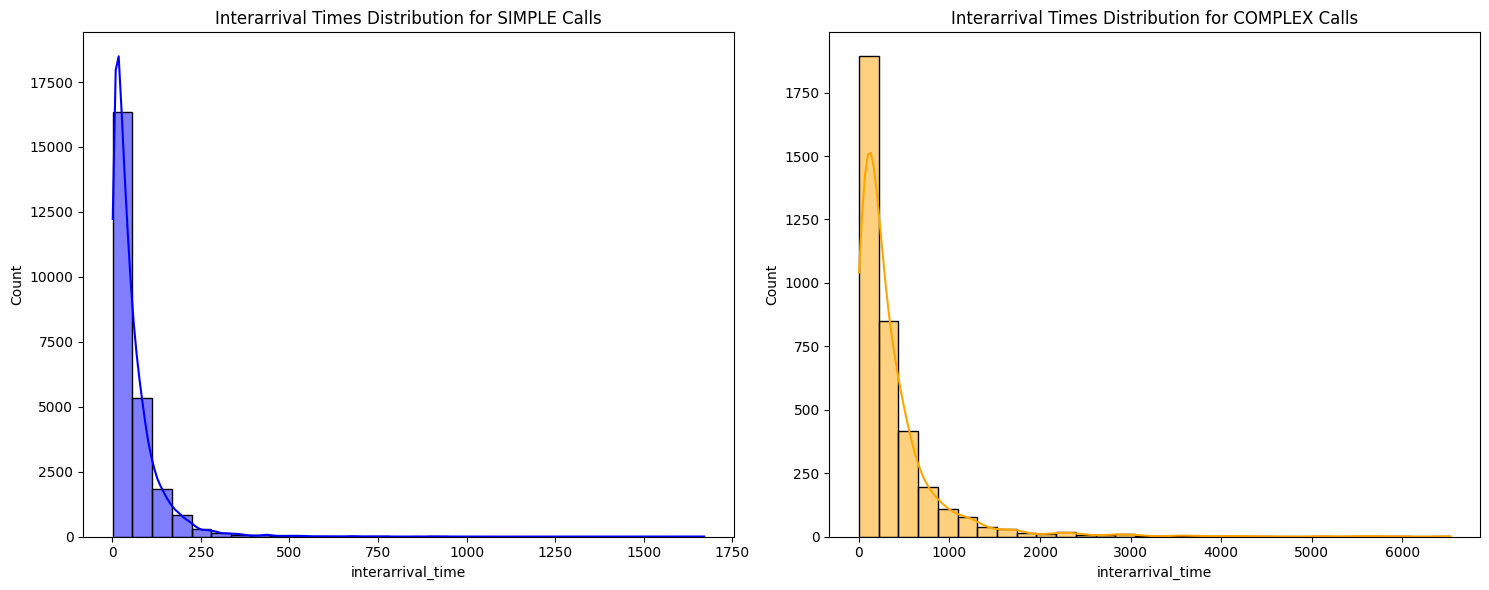

In [505]:
# Plot interarrival times distribution for both call types
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.histplot(cc_simple_df['interarrival_time'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Interarrival Times Distribution for SIMPLE Calls')
sns.histplot(cc_complex_df['interarrival_time'], bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Interarrival Times Distribution for COMPLEX Calls')
plt.tight_layout()
plt.show()

In [502]:
# Remove NA values in interarrival times
cc_simple_df = cc_simple_df.dropna(subset=['interarrival_time'])
cc_complex_df = cc_complex_df.dropna(subset=['interarrival_time'])

# KS on interarrival times
result_simple = ks_test_distributions_df(cc_simple_df['interarrival_time'])
result_complex = ks_test_distributions_df(cc_complex_df['interarrival_time'])

print("Simple Calls Interarrival Times Distribution Test Results:")
print(result_simple)
print("\nComplex Calls Interarrival Times Distribution Test Results:")
print(result_complex)

Simple Calls Interarrival Times Distribution Test Results:
             D-statistic       p-value  reject_null   best_fit
exponential     0.658844  0.000000e+00         True  lognormal
gamma           0.946032  0.000000e+00         True  lognormal
lognormal       0.037078  2.303520e-30         True  lognormal

Complex Calls Interarrival Times Distribution Test Results:
             D-statistic   p-value  reject_null   best_fit
exponential     0.685792  0.000000         True  lognormal
gamma           0.991004  0.000000         True  lognormal
lognormal       0.025393  0.016754         True  lognormal


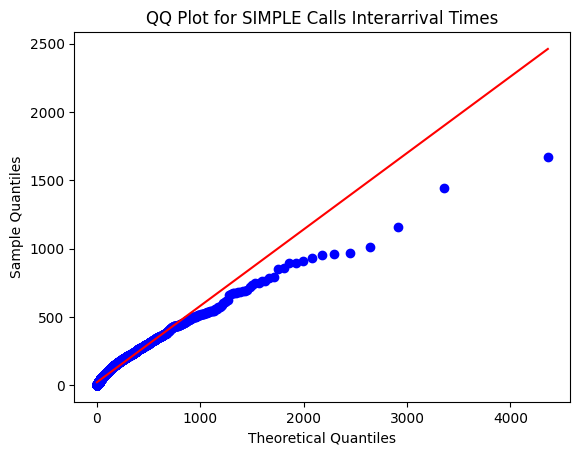

In [508]:
# QQ plots for interarrival times
qq_plot_lognorm(cc_simple_df['interarrival_time'], 'QQ Plot for SIMPLE Calls Interarrival Times')

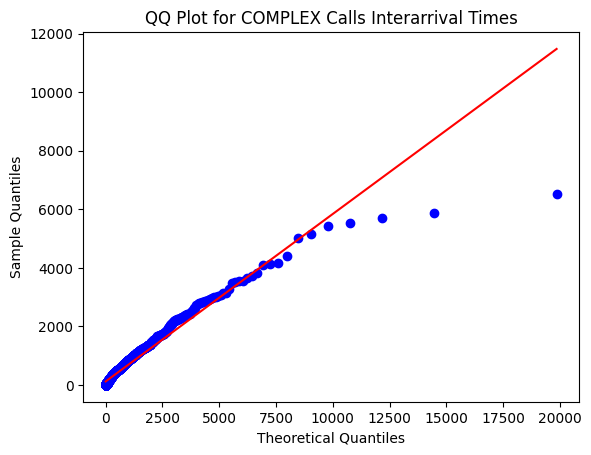

In [509]:
qq_plot_lognorm(cc_complex_df['interarrival_time'], 'QQ Plot for COMPLEX Calls Interarrival Times')

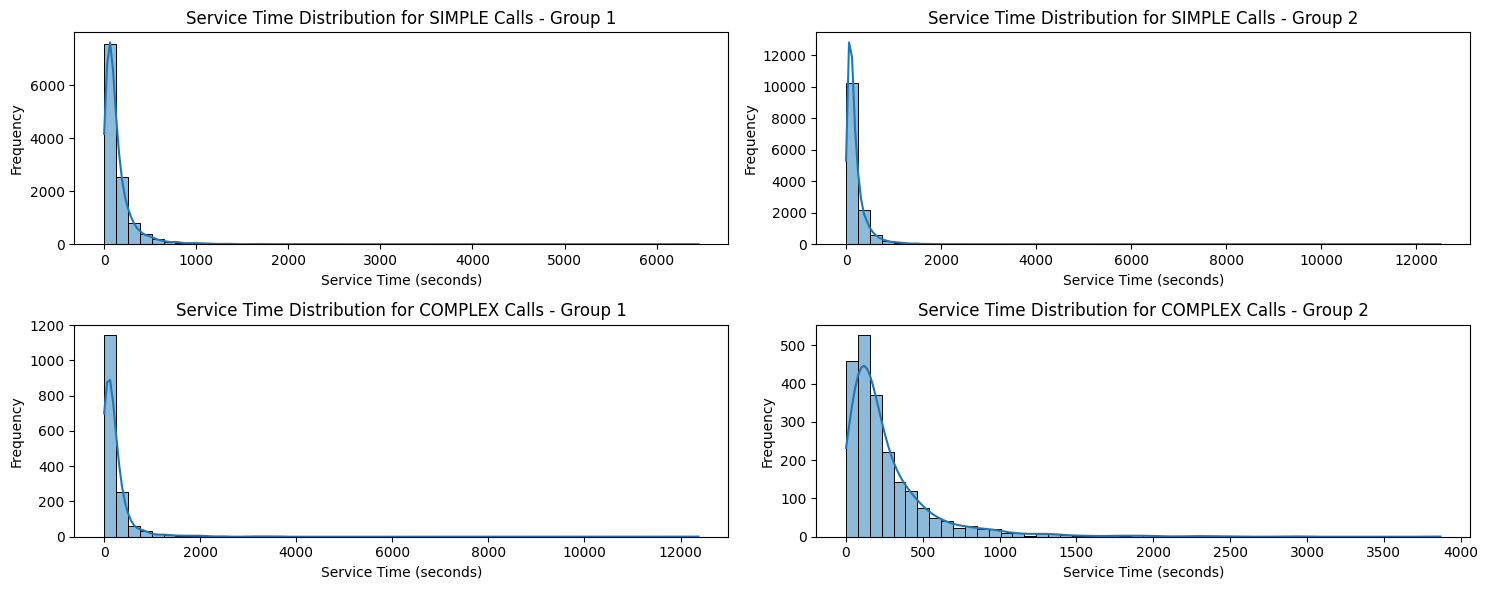

In [507]:
# Plot service time distributions for both call types and server groups
ct = ['SIMPLE', 'COMPLEX']
agents = ['1', '2']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
for i, call_type in enumerate(ct):
    for j, agent in enumerate(agents):
        ax = axes[i, j]
        sns.histplot(cc_final_df[(cc_final_df['type_group'] == call_type) & (cc_final_df['group_2'] == agent)]['ser_time'], bins=50, kde=True, ax=ax)
        ax.set_title(f'Service Time Distribution for {call_type} Calls - Group {agent}')
        ax.set_xlabel('Service Time (seconds)')
        ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


In [503]:
result_server_group = {}
for (group_2, type_group), group in cc_final_df.groupby(['group_2', 'type_group']):
    ser_time = group['ser_time']
    result_server_group[(group_2, type_group)] = ks_test_distributions_df(ser_time)
    print(f"{group_2} - {type_group}:\n", result_server_group[(group_2, type_group)], "\n")

1 - COMPLEX:
              D-statistic       p-value  reject_null   best_fit
exponential     0.711676  0.000000e+00         True  lognormal
gamma           0.971721  0.000000e+00         True  lognormal
lognormal       0.072278  2.073844e-07         True  lognormal 

1 - SIMPLE:
              D-statistic       p-value  reject_null   best_fit
exponential     0.689236  0.000000e+00         True  lognormal
gamma           0.975555  0.000000e+00         True  lognormal
lognormal       0.044194  3.061383e-20         True  lognormal 

2 - COMPLEX:
              D-statistic       p-value  reject_null   best_fit
exponential     0.682239  0.000000e+00         True  lognormal
gamma           0.058582  6.840656e-07         True  lognormal
lognormal       0.020628  3.121107e-01        False  lognormal 

2 - SIMPLE:
              D-statistic       p-value  reject_null   best_fit
exponential     0.685465  0.000000e+00         True  lognormal
gamma           0.998330  0.000000e+00         True  logno

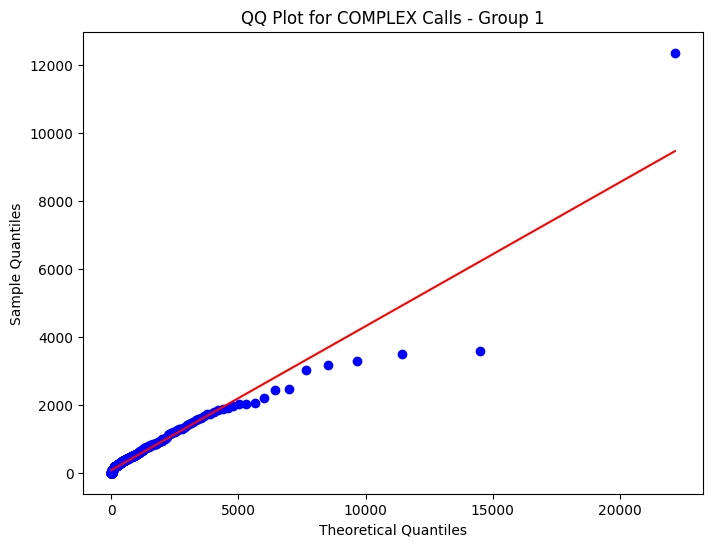

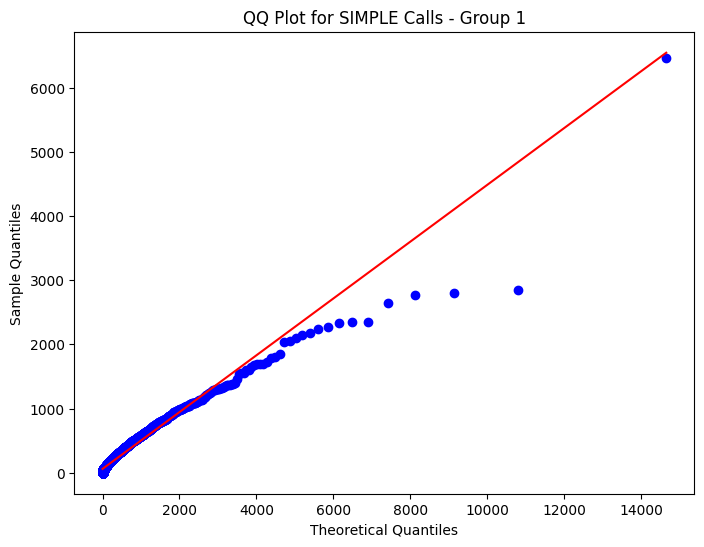

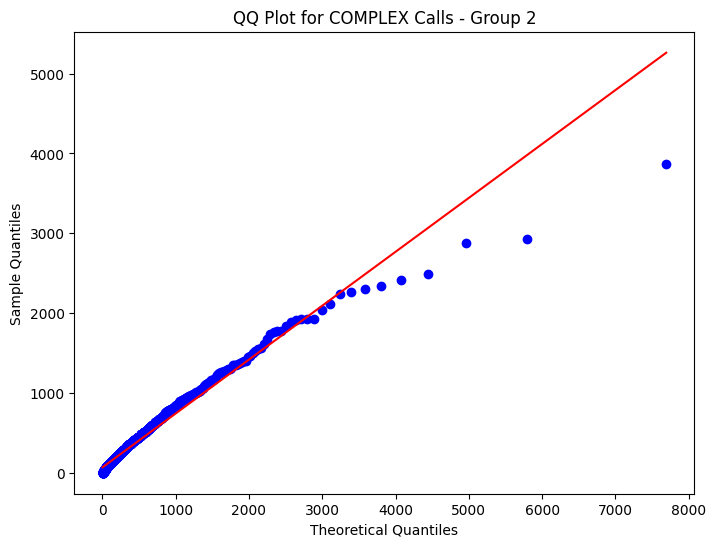

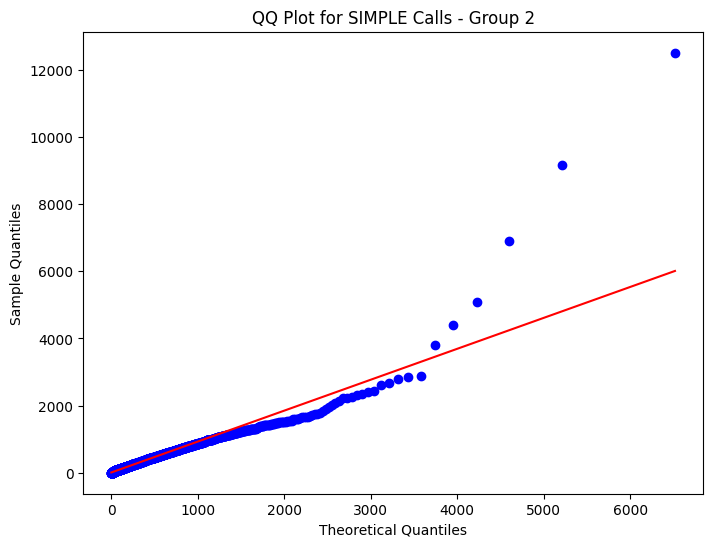

In [511]:
# Plot the service time QQ plots
for (group_2, type_group), group in cc_final_df.groupby(['group_2', 'type_group']):
    plt.figure(figsize=(8, 6))
    qq_plot_lognorm(group['ser_time'], f'QQ Plot for {type_group} Calls - Group {group_2}')
    plt.show()

In [512]:
# Collect the best fitting parameters for each results
best_fit_service_params = {}
for (group_2, type_group), df in result_server_group.items():
    best_fit = df['best_fit'].iloc[0]
    if best_fit == 'exponential':
        params = (df.loc['exponential', 'D-statistic'],)
    elif best_fit == 'gamma':
        params = stats.gamma.fit(cc_final_df[(cc_final_df['group_2'] == group_2) & (cc_final_df['type_group'] == type_group)]['ser_time'])
    elif best_fit == 'lognormal':
        params = stats.lognorm.fit(cc_final_df[(cc_final_df['group_2'] == group_2) & (cc_final_df['type_group'] == type_group)]['ser_time'])
    else:
        params = None
    best_fit_service_params[(group_2, type_group)] = params
    
print("Best fitting service time distribution parameters for each group and call type:")
for (group_2, type_group), params in best_fit_service_params.items():
    print(f"{group_2} - {type_group}: {params}")

Best fitting service time distribution parameters for each group and call type:
1 - COMPLEX: (np.float64(1.204511467147714), -9.755593679326038, np.float64(119.24909591789675))
1 - SIMPLE: (np.float64(0.9261161935026054), -13.961890656808079, np.float64(104.50676710322796))
2 - COMPLEX: (np.float64(0.9070418221009697), -17.41269162958764, np.float64(192.3101172153293))
2 - SIMPLE: (np.float64(0.8551150573776538), -12.157121613393747, np.float64(146.23142143889223))


In [513]:
shape_simple, loc_simple, scale_simple = stats.lognorm.fit(cc_simple_df['ser_time'])
shape_complex, loc_complex, scale_complex = stats.lognorm.fit(cc_complex_df['ser_time'])

In [517]:
# Place the params in a dataframe
best_fit_params_df = pd.DataFrame.from_dict(best_fit_service_params, orient='index', columns=['shape', 'loc', 'scale'])

best_fit_params_df = best_fit_params_df.reset_index().rename(columns={'index': 'param_name'})

# Add the shape, loc, and scale for simple and complex calls
best_fit_interarrival_df = pd.DataFrame([
    {'param_name': 'SIMPLE', 'shape': shape_simple, 'loc': loc_simple, 'scale': scale_simple},
    {'param_name': 'COMPLEX', 'shape': shape_complex, 'loc': loc_complex, 'scale': scale_complex}
])

# Concatenate the best fit parameters for service times and interarrival times
best_fit_params_df = pd.concat([best_fit_params_df, best_fit_interarrival_df], ignore_index=True)

best_fit_params_df


,param_name,shape,loc,scale
0,"(1, COMPLEX)",1.204511,-9.755594,119.249096
1,"(1, SIMPLE)",0.926116,-13.961891,104.506767
2,"(2, COMPLEX)",0.907042,-17.412692,192.310117
3,"(2, SIMPLE)",0.855115,-12.157122,146.231421
4,SIMPLE,0.881651,-15.594575,128.663410
5,COMPLEX,0.987725,-18.410834,167.117964


In [520]:
# Calculate mu and sigma for lognormal distribution from the best fitting parameters
lognorm_params = {}
for (group_2, type_group), params in best_fit_service_params.items():
    if isinstance(params, tuple) and len(params) == 3:  # lognormal parameters
        shape, loc, scale = params
        mu = np.log(scale)
        sigma = shape
        lognorm_params[(group_2, type_group)] = (mu, sigma)
    else:
        lognorm_params[(group_2, type_group)] = None
        
lognorm_params_df = pd.DataFrame.from_dict(lognorm_params, orient='index', columns=['mu', 'sigma'])

lognorm_params_df

,mu,sigma
"(1, COMPLEX)",4.781215,1.204511
"(1, SIMPLE)",4.649252,0.926116
"(2, COMPLEX)",5.259109,0.907042
"(2, SIMPLE)",4.985190,0.855115
